<a href="https://colab.research.google.com/github/AvdMei/AI_Bullshit_Detector/blob/ages_branch/AI_Bullshit_Detector_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI Bullshit Detector

Team: Age, Anika, Nate

Attribution: LiquidAI (model builder), HuggingFace (hosting)

LLM mode: LiquidAI LMF2-1.2B

Sundai project 11-jan-26

In [ ]:
# =============================================================================
# CELL 1: Install dependencies
# =============================================================================
# !pip install -q transformers>=4.55.0 torch tqdm

In [2]:
# =============================================================================
# CELL 2: Imports and Setup
# =============================================================================

from dataclasses import dataclass
from typing import Optional, Tuple, Dict, List
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers.utils import ModelOutput
from tqdm import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cuda


In [3]:
# =============================================================================
# CELL 3: Output Dataclass
# =============================================================================

@dataclass
class Lfm2IDKOutput(ModelOutput):
    """Output with IDK score."""
    loss: Optional[torch.FloatTensor] = None
    logits: Optional[torch.FloatTensor] = None
    idk_score: Optional[torch.FloatTensor] = None
    idk_components: Optional[dict] = None
    past_key_values: Optional[Tuple] = None
    hidden_states: Optional[Tuple] = None


# =============================================================================
# CELL 4: IDK Head Components
# =============================================================================

class FlowPredictor(nn.Module):
    """Predicts z12 from z8. High error = out-of-distribution."""

    def __init__(self, hidden_dim: int = 2048, bottleneck_dim: int = 512, dropout: float = 0.1):
        super().__init__()
        self.predictor = nn.Sequential(
            nn.Linear(hidden_dim, bottleneck_dim),
            nn.GELU(),
            nn.LayerNorm(bottleneck_dim),
            nn.Dropout(dropout),
            nn.Linear(bottleneck_dim, bottleneck_dim),
            nn.GELU(),
            nn.LayerNorm(bottleneck_dim),
            nn.Dropout(dropout),
            nn.Linear(bottleneck_dim, hidden_dim),
        )
        self.error_scale = nn.Parameter(torch.tensor(1.0))
        self.error_bias = nn.Parameter(torch.tensor(0.0))

    def forward(self, z8: torch.Tensor) -> torch.Tensor:
        return self.predictor(z8)

    def compute_error(self, z8: torch.Tensor, z12: torch.Tensor) -> torch.Tensor:
        z12_pred = self.forward(z8)
        mse = F.mse_loss(z12_pred, z12, reduction='none').mean(dim=-1)
        return torch.sigmoid(self.error_scale * mse + self.error_bias)


class HeadDisagreementModule(nn.Module):
    """Computes KV head disagreement. High variance = uncertainty."""

    def __init__(self):
        super().__init__()
        self.scale = nn.Parameter(torch.tensor(1.0))
        self.bias = nn.Parameter(torch.tensor(0.0))

    def forward(self, kv_8: Tuple, kv_12: Tuple) -> torch.Tensor:
        d8 = self._compute_disagreement(kv_8)
        d12 = self._compute_disagreement(kv_12)
        avg = (d8 + d12) / 2
        return torch.sigmoid(self.scale * avg + self.bias)

    def _compute_disagreement(self, kv: Tuple) -> torch.Tensor:
        k, v = kv
        if k.numel() == 0:
            return torch.zeros(1, device=k.device)
        k_last = k[:, :, -1, :].float()
        v_last = v[:, :, -1, :].float()
        return k_last.var(dim=1).mean(dim=-1) + v_last.var(dim=1).mean(dim=-1)


class EntropyModule(nn.Module):
    """Computes normalized output entropy."""

    def __init__(self, vocab_size: int = 65536):
        super().__init__()
        self.max_entropy = torch.log(torch.tensor(float(vocab_size)))
        self.scale = nn.Parameter(torch.tensor(1.0))
        self.bias = nn.Parameter(torch.tensor(0.0))

    def forward(self, logits: torch.Tensor) -> torch.Tensor:
        if logits.dim() == 3:
            logits = logits[:, -1, :]
        probs = F.softmax(logits.float(), dim=-1)
        entropy = -(probs * torch.log(probs + 1e-10)).sum(dim=-1)
        normalized = entropy / self.max_entropy.to(logits.device)
        return torch.sigmoid(self.scale * normalized + self.bias)


class IDKHead(nn.Module):
    """
    IDK Head: Combines flow prediction, head disagreement, and entropy
    into a single uncertainty score from 0-100.
    """

    def __init__(
        self,
        hidden_dim: int = 2048,
        bottleneck_dim: int = 512,
        dropout: float = 0.1,
        vocab_size: int = 65536,
        flow_weight: float = 0.4,
        head_weight: float = 0.3,
        entropy_weight: float = 0.3
    ):
        super().__init__()

        self.flow_predictor = FlowPredictor(hidden_dim, bottleneck_dim, dropout)
        self.head_disagreement = HeadDisagreementModule()
        self.entropy_module = EntropyModule(vocab_size)

        self.flow_weight = flow_weight
        self.head_weight = head_weight
        self.entropy_weight = entropy_weight

    def forward(
        self,
        z8: torch.Tensor = None,
        z12: torch.Tensor = None,
        kv_cache_8: Tuple = None,
        kv_cache_12: Tuple = None,
        logits: torch.Tensor = None
    ) -> Tuple[torch.Tensor, dict]:

        components = {}
        signals = []
        weights = []

        # 1. Flow prediction error
        if z8 is not None and z12 is not None:
            flow_error = self.flow_predictor.compute_error(z8, z12)
            components['flow_error'] = flow_error.item() if flow_error.dim() == 0 else flow_error[0].item()
            signals.append(flow_error)
            weights.append(self.flow_weight)

        # 2. Head disagreement
        if kv_cache_8 is not None and kv_cache_12 is not None:
            head_disagree = self.head_disagreement(kv_cache_8, kv_cache_12)
            components['head_disagreement'] = head_disagree.item() if head_disagree.dim() == 0 else head_disagree[0].item()
            signals.append(head_disagree)
            weights.append(self.head_weight)

        # 3. Entropy
        if logits is not None:
            entropy_signal = self.entropy_module(logits)
            components['entropy_signal'] = entropy_signal.item() if entropy_signal.dim() == 0 else entropy_signal[0].item()
            signals.append(entropy_signal)
            weights.append(self.entropy_weight)

        # Combine signals
        if len(signals) == 0:
            return torch.tensor([50.0]), components

        # Normalize weights
        total_weight = sum(weights)
        weights = [w / total_weight for w in weights]

        # Weighted sum
        combined = sum(s * w for s, w in zip(signals, weights))
        idk_score = combined * 100

        return idk_score, components

In [4]:
# =============================================================================
# CELL 5: Wrapper Class (Simplified - avoids recursion)
# =============================================================================

class LFM2WithIDK(nn.Module):
    """
    LFM2 with IDK uncertainty head.

    This is a simple nn.Module wrapper (not PreTrainedModel) to avoid
    recursion issues. For HuggingFace Hub hosting, use the full package version.
    """

    def __init__(
        self,
        base_model,  # Pass pre-loaded model
        hidden_dim: int = 2048,
        bottleneck_dim: int = 512,
        layer_8_idx: int = 8,
        layer_12_idx: int = 12,
    ):
        super().__init__()

        # Store base model (already loaded)
        self.lm = base_model

        # Freeze base model
        for param in self.lm.parameters():
            param.requires_grad = False

        # IDK Head
        self.idk_head = IDKHead(
            hidden_dim=hidden_dim,
            bottleneck_dim=bottleneck_dim,
        )

        # Layer indices (hidden_states[0] is embeddings, so +1)
        self.z8_idx = layer_8_idx + 1  # 9
        self.z12_idx = layer_12_idx + 1  # 13
        self.layer_8_idx = layer_8_idx
        self.layer_12_idx = layer_12_idx

    def forward(
        self,
        input_ids: torch.Tensor,
        attention_mask: torch.Tensor = None,
        past_key_values = None,
        output_idk_score: bool = True,
    ) -> Lfm2IDKOutput:

        # Forward through base model
        outputs = self.lm(
            input_ids=input_ids,
            attention_mask=attention_mask,
            past_key_values=past_key_values,
            use_cache=True,
            output_hidden_states=True,
            return_dict=True,
        )

        idk_score = None
        idk_components = None

        if output_idk_score and outputs.hidden_states is not None:
            # Extract z8, z12
            z8 = outputs.hidden_states[self.z8_idx][:, -1, :].float()
            z12 = outputs.hidden_states[self.z12_idx][:, -1, :].float()

            # Extract KV caches
            kv_cache_8, kv_cache_12 = None, None

            if outputs.past_key_values is not None:
                cache = outputs.past_key_values
                try:
                    kv_8 = cache[self.layer_8_idx]
                    kv_12 = cache[self.layer_12_idx]

                    if isinstance(kv_8, tuple) and len(kv_8) >= 2:
                        if kv_8[0].numel() > 0:
                            kv_cache_8 = (kv_8[0].float(), kv_8[1].float())

                    if isinstance(kv_12, tuple) and len(kv_12) >= 2:
                        if kv_12[0].numel() > 0:
                            kv_cache_12 = (kv_12[0].float(), kv_12[1].float())
                except (IndexError, TypeError, AttributeError):
                    pass

            # Compute IDK score
            idk_score, idk_components = self.idk_head(
                z8=z8,
                z12=z12,
                kv_cache_8=kv_cache_8,
                kv_cache_12=kv_cache_12,
                logits=outputs.logits.float()
            )

        return Lfm2IDKOutput(
            logits=outputs.logits,
            idk_score=idk_score,
            idk_components=idk_components,
            past_key_values=outputs.past_key_values,
            hidden_states=outputs.hidden_states,
        )

    def get_idk_parameters(self):
        """Get only IDK head parameters for training."""
        return self.idk_head.parameters()


# =============================================================================
# CELL 6: Training Data Extraction
# =============================================================================

def extract_samples_from_base_model(base_model, tokenizer, prompts, max_tokens=50):
    """
    Extract (z8, z12) training pairs from the base model.
    Uses the base model directly to avoid wrapper issues.
    """
    template = "<|startoftext|><|im_start|>user\n{question}<|im_end|>\n<|im_start|>assistant\n"
    samples = []

    base_model.eval()
    device = next(base_model.parameters()).device

    for prompt in tqdm(prompts, desc="Extracting samples"):
        input_text = template.format(question=prompt)
        input_ids = tokenizer.encode(input_text, return_tensors="pt").to(device)

        past = None
        current = input_ids

        for step in range(max_tokens):
            with torch.no_grad():
                outputs = base_model(
                    input_ids=current,
                    past_key_values=past,
                    use_cache=True,
                    output_hidden_states=True,
                    return_dict=True
                )

            # Extract hidden states
            # Layer 8 output is at index 9, layer 12 is at index 13
            hs = outputs.hidden_states
            z8 = hs[9][:, -1, :].float().cpu().squeeze(0)
            z12 = hs[13][:, -1, :].float().cpu().squeeze(0)

            samples.append({'z8': z8, 'z12': z12})

            # Get next token
            next_logits = outputs.logits[:, -1, :]
            next_token = next_logits.argmax(dim=-1)

            # Check EOS
            if next_token.item() == tokenizer.eos_token_id:
                break

            # Update for next step
            past = outputs.past_key_values
            current = next_token.unsqueeze(0)

    return samples


# =============================================================================
# CELL 7: Training Function
# =============================================================================

class SampleDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]


def train_idk_head(model, samples, epochs=20, lr=1e-4, batch_size=64):
    """Train the IDK head using flow prediction loss."""

    dataset = SampleDataset(samples)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=False)

    device = next(model.idk_head.parameters()).device
    optimizer = torch.optim.AdamW(model.get_idk_parameters(), lr=lr, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    print(f"Training on {len(samples)} samples, {len(loader)} batches per epoch")

    model.idk_head.train()

    for epoch in range(epochs):
        total_loss = 0
        num_batches = 0

        for batch in loader:
            z8 = batch['z8'].to(device)
            z12 = batch['z12'].to(device)

            # Flow prediction loss
            z12_pred = model.idk_head.flow_predictor(z8)
            loss = F.mse_loss(z12_pred, z12)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.idk_head.parameters(), 1.0)
            optimizer.step()

            total_loss += loss.item()
            num_batches += 1

        scheduler.step()
        avg_loss = total_loss / num_batches

        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d}/{epochs} | Loss: {avg_loss:.6f}")

    model.idk_head.eval()
    return model


# =============================================================================
# CELL 8: RUN THE COMPLETE PIPELINE
# =============================================================================

# --- STEP 1: Load base model and tokenizer ---
print("=" * 60)
print("STEP 1: Loading LFM2 base model...")
print("=" * 60)

tokenizer = AutoTokenizer.from_pretrained("LiquidAI/LFM2-1.2B")
base_model = AutoModelForCausalLM.from_pretrained(
    "LiquidAI/LFM2-1.2B",
    torch_dtype=torch.float32,
    device_map="auto"
)

print(f"Base model loaded on {base_model.device}")

# --- STEP 2: Create wrapper with IDK head ---
print("\n" + "=" * 60)
print("STEP 2: Creating LFM2 + IDK wrapper...")
print("=" * 60)

model = LFM2WithIDK(base_model=base_model)
model.to(DEVICE)

idk_params = sum(p.numel() for p in model.idk_head.parameters())
print(f"IDK head parameters: {idk_params:,}")

# --- STEP 3: Prepare training prompts ---
print("\n" + "=" * 60)
print("STEP 3: Preparing training prompts...")
print("=" * 60)

training_prompts = [

    # =========================================================================
    # CATEGORY 1: FACTUAL - COMMON KNOWLEDGE (Model should be CONFIDENT)
    # =========================================================================

    # Geography
    "What is the capital of France?",
    "What is the capital of Japan?",
    "What is the capital of Germany?",
    "What is the capital of Australia?",
    "What is the capital of Brazil?",
    "What is the capital of Canada?",
    "What is the capital of Egypt?",
    "What is the capital of India?",
    "What is the largest country by land area?",
    "What is the smallest country in the world?",
    "How many continents are there?",
    "What is the longest river in the world?",
    "What is the largest ocean?",
    "What is the tallest mountain on Earth?",

    # Science basics
    "What is water made of?",
    "What is the chemical formula for water?",
    "What is the chemical symbol for gold?",
    "What is the chemical symbol for oxygen?",
    "How many planets are in our solar system?",
    "What is the closest planet to the Sun?",
    "What is the largest planet in our solar system?",
    "What is the speed of light?",
    "What is the boiling point of water in Celsius?",
    "What is the freezing point of water in Fahrenheit?",

    # History & Literature
    "Who wrote Hamlet?",
    "Who wrote Romeo and Juliet?",
    "Who wrote 1984?",
    "Who wrote Pride and Prejudice?",
    "Who painted the Mona Lisa?",
    "Who invented the telephone?",
    "Who invented the light bulb?",
    "What year did World War 2 end?",
    "What year did World War 1 begin?",
    "Who was the first person to walk on the moon?",

    # Math & Numbers
    "What is 2 + 2?",
    "What is the square root of 144?",
    "How many days are in a year?",
    "How many hours are in a day?",
    "How many seconds are in a minute?",
    "What is the value of pi to two decimal places?",

    # =========================================================================
    # CATEGORY 2: TECHNICAL - EXPLANATIONS (Model should be moderately confident)
    # =========================================================================

    "Explain how neural networks learn",
    "What is machine learning?",
    "How does photosynthesis work?",
    "What is quantum entanglement?",
    "What is the difference between TCP and UDP?",
    "Explain the theory of relativity",
    "What is CRISPR gene editing?",
    "How do vaccines work?",
    "What is blockchain technology?",
    "How does encryption work?",
    "What is an algorithm?",
    "Explain how a CPU processes instructions",
    "What is the difference between RAM and ROM?",
    "How does GPS work?",
    "What is artificial intelligence?",
    "Explain the water cycle",
    "How do airplanes fly?",
    "What causes earthquakes?",
    "How does the immune system work?",
    "What is DNA and how does it work?",
    "Explain how batteries store energy",
    "What is the difference between AC and DC current?",

    # =========================================================================
    # CATEGORY 3: RECENT/TEMPORAL (Model should be UNCERTAIN - data cutoff)
    # =========================================================================

    "Who won the most recent Super Bowl?",
    "What is the current stock price of Apple?",
    "Who is the current president of France?",
    "Who is the current CEO of Twitter?",
    "What was the weather yesterday in New York?",
    "What movies came out this week?",
    "What is the current price of Bitcoin?",
    "Who won the most recent Grammy for Album of the Year?",
    "What is the current population of the world?",
    "Who won the last FIFA World Cup?",
    "What is the current interest rate set by the Federal Reserve?",
    "What was the closing price of the S&P 500 yesterday?",

    # =========================================================================
    # CATEGORY 4: SUBJECTIVE/OPINION (Model should be UNCERTAIN)
    # =========================================================================

    "What is the best programming language?",
    "Is pineapple good on pizza?",
    "What is the meaning of life?",
    "What is the best movie ever made?",
    "Should I learn Python or JavaScript?",
    "What is the best country to live in?",
    "Is coffee better than tea?",
    "What is the best music genre?",
    "Should I buy a Mac or PC?",
    "What is the most beautiful city in the world?",
    "Is it better to rent or buy a house?",
    "What is the best way to learn a new language?",
    "Should I exercise in the morning or evening?",
    "What is the best career choice for someone who likes math?",
    "Is reading better than watching movies?",

    # =========================================================================
    # CATEGORY 5: IMPOSSIBLE - FUTURE PREDICTIONS (Model should be VERY UNCERTAIN)
    # =========================================================================

    "What will happen tomorrow?",
    "Who will win the next election?",
    "What will the stock market do next week?",
    "Will it rain on my birthday?",
    "What will AI look like in 100 years?",
    "Who will win the next World Cup?",
    "What will be the next major scientific discovery?",
    "When will humans land on Mars?",
    "What will be the biggest news story next month?",
    "Will there be a recession next year?",
    "What company will be the most valuable in 10 years?",
    "What will be the next pandemic?",

    # =========================================================================
    # CATEGORY 6: IMPOSSIBLE - PERSONAL/PRIVATE (Model CANNOT know)
    # User-provided questions about personal unknowable information
    # =========================================================================

    "What will I personally eat for dinner tomorrow night?",
    "What number am I thinking of right now?",
    "What will be the first typo I make tomorrow?",
    "What is the password to my personal email account?",
    "What will be the exact time I fall asleep tonight?",
    "What decision will I make five minutes from now?",
    "What is written on the last sticky note I used?",
    "What will the weather be at my exact location in 30 days?",
    "What song will get stuck in my head next?",
    "What is inside the unopened box on my desk?",
    "What will be the next thought I have?",
    "What will be the next object I touch?",
    "What will my mood be exactly at noon tomorrow?",
    "What private message did I last delete?",
    "What will be the exact price of gas at my nearest station tomorrow?",
    "What will be the next dream I remember?",
    "What will I write as my next password?",
    "What will be the next mistake I make today?",
    "What will be the exact wording of my next text message?",
    "What will be the last thing I think about before I fall asleep tonight?",

    # =========================================================================
    # CATEGORY 7: OBSCURE FACTUAL (Model likely UNCERTAIN - rare knowledge)
    # User-provided questions about obscure facts
    # =========================================================================

    "Who received the IEEE Frank Rosenblatt Award in 2010?",
    "Who was awarded the Oceanography Society's Jerlov Award in 2018?",
    "What's the name of the women's liberal arts college in Cambridge, Massachusetts?",
    "In whose honor was the Leipzig 1877 tournament organized?",
    "According to Karl Küchler, what did Empress Elizabeth of Austria's favorite sculpture depict, which was made for her villa Achilleion at Corfu?",
    "How much money, in euros, was the surgeon held responsible for Stella Obasanjo's death ordered to pay her son?",
    "What were the month and year when Obama told Christianity Today, 'I am a Christian, and I am a devout Christian. I believe in the redemptive death and resurrection of Jesus Christ'?",
    "Who appointed the Chief Justice of India, Mirza Hameedullah Beg, in 1977?",
    "What is the name of the former Prime Minister of Iceland who worked as a cabin crew member until 1971?",
    "To whom did Mehbooba Mufti Sayed contest the 2019 Lok Sabha elections and lose?",
    "How many fouls did Inter commit in the Champions League final match between Bayern and Inter on May 23, 2010?",
    "What year did the Lego part with ID gal56 first release?",
    "In which year did the Japanese scientist Koichi Mizushima receive the Kato Memorial Prize?",
    "In which year did Melbourne's Monash Gallery of Art (MGA) rebrand and become the Museum of Australian Photography (MAPh)?",
    "Who requested the Federal Aviation Administration (FAA) implement a 900 sq mi (2,300 km²) temporary flight restriction zone over the operations areas of the Deepwater Horizon?",
    "What signature piece of the MOBA did Scott Wilson discover on the curb between two trash cans?",
    "What player scored all the conversions for Spain in the rugby match between Spain and Romania that was part of the 2022 Rugby Europe Championship on February 27, 2022?",
    "What is the surname of the psychiatrist who prescribes medication for Marie Hanson for her periodic blackouts in Season 1, Episode 20 of Ally McBeal?",
    "What is the British-American kickboxer Andrew Tate's kickboxing name?",
    "What position was John Gilbert Layton appointed to in Quebec from 1969 until 1970?",

    # =========================================================================
    # CATEGORY 8: ADDITIONAL OBSCURE/TRIVIA (Model likely UNCERTAIN)
    # =========================================================================

    "What is the population of Tuvalu?",
    "Who was the 23rd Prime Minister of Canada?",
    "What is the atomic weight of Lawrencium?",
    "What is the GDP of Liechtenstein?",
    "Who won the Nobel Prize in Chemistry in 1987?",
    "What is the deepest point in the Indian Ocean?",
    "Who was the Roman Emperor in 117 AD?",
    "What is the national bird of Bhutan?",
    "Who designed the Sydney Opera House?",
    "What year was the Treaty of Westphalia signed?",
    "What is the chemical formula for rust?",
    "Who invented the zipper?",
    "What is the currency of Myanmar?",
    "What is the second largest moon of Saturn?",
    "Who wrote the novel 'The Master and Margarita'?",
    "What year was the first email sent?",
    "What is the tallest building in South America?",
    "Who was the first female Prime Minister of Pakistan?",
    "What is the capital of Burkina Faso?",
    "What element has the atomic number 79?",

    # =========================================================================
    # CATEGORY 9: ADDITIONAL IMPOSSIBLE/RANDOM (Model should be VERY UNCERTAIN)
    # =========================================================================

    "What am I thinking right now?",
    "What will be the lottery numbers next week?",
    "What is the exact number of grains of sand on Earth?",
    "What will be the exact temperature at noon tomorrow in my backyard?",
    "How many birds are flying right now?",
    "What will be the next word I type?",
    "What color socks am I wearing?",
    "What did I have for breakfast three weeks ago?",
    "What will be trending on social media tomorrow?",
    "What is my favorite color?",
    "How many times will I blink today?",
    "What will be my next Google search?",
    "What will I name my future pet?",
    "What time will I wake up next Saturday?",
    "What will be the headline news in exactly one year?",

    # =========================================================================
    # CATEGORY 10: PARADOXES AND UNANSWERABLE (Model should be VERY UNCERTAIN)
    # =========================================================================

    "What happens when an unstoppable force meets an immovable object?",
    "Can God create a rock so heavy that even God cannot lift it?",
    "If a tree falls in a forest and no one is around, does it make a sound?",
    "What existed before the universe?",
    "What is north of the North Pole?",
    "What is the sound of one hand clapping?",
    "Why is there something rather than nothing?",
    "What is outside the universe?",
    "Can you prove that reality is not a simulation?",
    "What is the last digit of pi?",
]

print(f"Prepared {len(training_prompts)} diverse prompts")

# --- STEP 4: Extract training samples ---
print("\n" + "=" * 60)
print("STEP 4: Extracting training samples...")
print("=" * 60)

samples = extract_samples_from_base_model(
    base_model=base_model,  # Use base model directly
    tokenizer=tokenizer,
    prompts=training_prompts,
    max_tokens=30
)

print(f"Extracted {len(samples)} (z8, z12) pairs")

# --- STEP 5: Train IDK head ---
print("\n" + "=" * 60)
print("STEP 5: Training IDK head...")
print("=" * 60)

model = train_idk_head(model, samples, epochs=15, lr=1e-4, batch_size=32)

# --- STEP 6: Test inference ---
print("\n" + "=" * 60)
print("STEP 6: Testing inference with IDK scores...")
print("=" * 60)

test_prompts = [
    ("What is 2 + 2?", "Should be CONFIDENT"),
    ("What is the capital of France?", "Should be CONFIDENT"),
    ("What is the meaning of life?", "Should be UNCERTAIN"),
    ("Who will win the lottery tomorrow?", "Should be VERY UNCERTAIN"),
    ("What is the 1000th digit of pi?", "Should be VERY UNCERTAIN"),
]

template = "<|startoftext|><|im_start|>user\n{question}<|im_end|>\n<|im_start|>assistant\n"

model.eval()
print("\nResults:")
print("-" * 70)

for question, expected in test_prompts:
    input_text = template.format(question=question)
    input_ids = tokenizer.encode(input_text, return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        outputs = model(input_ids, output_idk_score=True)

    idk = outputs.idk_score
    if isinstance(idk, torch.Tensor):
        idk = idk.item() if idk.numel() == 1 else idk[0].item()

    # Interpret
    if idk < 20:
        conf = "🟢 Very Confident"
    elif idk < 40:
        conf = "🟡 Confident"
    elif idk < 60:
        conf = "🟠 Uncertain"
    elif idk < 80:
        conf = "🔴 Low Confidence"
    else:
        conf = "⚫ Very Uncertain"

    print(f"\nQ: {question}")
    print(f"   IDK Score: {idk:.1f}/100 {conf}")
    print(f"   Expected: {expected}")
    if outputs.idk_components:
        print(f"   Components: {outputs.idk_components}")

print("\n" + "=" * 60)
print("✅ COMPLETE!")
print("=" * 60)


# =============================================================================
# CELL 9: (OPTIONAL) Generate text with per-token IDK
# =============================================================================

def generate_with_idk(model, tokenizer, prompt, max_tokens=30, temperature=0.3):
    """Generate text with per-token IDK scores."""
    template = "<|startoftext|><|im_start|>user\n{question}<|im_end|>\n<|im_start|>assistant\n"
    input_text = template.format(question=prompt)
    input_ids = tokenizer.encode(input_text, return_tensors="pt").to(DEVICE)

    generated_tokens = []
    idk_scores = []

    current = input_ids
    past = None

    model.eval()
    for _ in range(max_tokens):
        with torch.no_grad():
            outputs = model(current, past_key_values=past, output_idk_score=True)

        # Get IDK score
        idk = outputs.idk_score
        if isinstance(idk, torch.Tensor):
            idk = idk.item() if idk.numel() == 1 else idk[0].item()
        idk_scores.append(idk)

        # Sample next token
        logits = outputs.logits[:, -1, :]
        if temperature > 0:
            probs = F.softmax(logits / temperature, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
        else:
            next_token = logits.argmax(dim=-1, keepdim=True)

        generated_tokens.append(next_token.item())

        # Check EOS
        if next_token.item() == tokenizer.eos_token_id:
            break

        past = outputs.past_key_values
        current = next_token

    text = tokenizer.decode(generated_tokens, skip_special_tokens=True)

    return {
        'text': text,
        'tokens': generated_tokens,
        'idk_scores': idk_scores,
        'mean_idk': sum(idk_scores) / len(idk_scores) if idk_scores else 0,
    }


# Test generation
print("\n" + "=" * 60)
print("BONUS: Generation with per-token IDK")
print("=" * 60)

result = generate_with_idk(model, tokenizer, "What is machine learning?", max_tokens=20)
print(f"\nQuestion: What is machine learning?")
print(f"Answer: {result['text']}")
print(f"Mean IDK: {result['mean_idk']:.1f}/100")
print(f"\nPer-token IDK scores:")
for i, (tok, idk) in enumerate(zip(result['tokens'], result['idk_scores'])):
    tok_str = tokenizer.decode([tok])
    print(f"  {i}: '{tok_str}' -> IDK: {idk:.1f}")

Using device: cuda
STEP 1: Loading LFM2 base model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/434 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/2.34G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

Base model loaded on cuda:0

STEP 2: Creating LFM2 + IDK wrapper...
IDK head parameters: 2,364,422

STEP 3: Preparing training prompts...
Prepared 186 diverse prompts

STEP 4: Extracting training samples...


Extracting samples: 100%|██████████| 186/186 [01:40<00:00,  1.85it/s]


Extracted 5344 (z8, z12) pairs

STEP 5: Training IDK head...
Training on 5344 samples, 167 batches per epoch
Epoch   1/15 | Loss: 0.115839
Epoch   5/15 | Loss: 0.051918
Epoch  10/15 | Loss: 0.040745
Epoch  15/15 | Loss: 0.039628

STEP 6: Testing inference with IDK scores...

Results:
----------------------------------------------------------------------

Q: What is 2 + 2?
   IDK Score: 63.6/100 🔴 Low Confidence
   Expected: Should be CONFIDENT
   Components: {'flow_error': 0.5061379671096802, 'head_disagreement': 0.9274423718452454, 'entropy_signal': 0.5170724391937256}

Q: What is the capital of France?
   IDK Score: 63.2/100 🔴 Low Confidence
   Expected: Should be CONFIDENT
   Components: {'flow_error': 0.5049847960472107, 'head_disagreement': 0.9281729459762573, 'entropy_signal': 0.5042762756347656}

Q: What is the meaning of life?
   IDK Score: 63.1/100 🔴 Low Confidence
   Expected: Should be UNCERTAIN
   Components: {'flow_error': 0.5069972276687622, 'head_disagreement': 0.9245220

# Visualisation

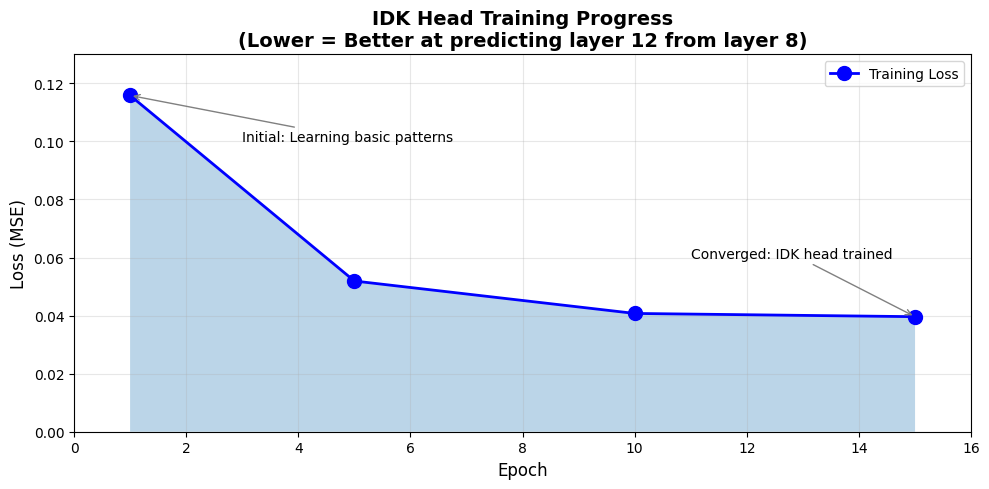


The IDK head learns to predict how information flows through the model.
Lower loss = better understanding of normal model behavior.



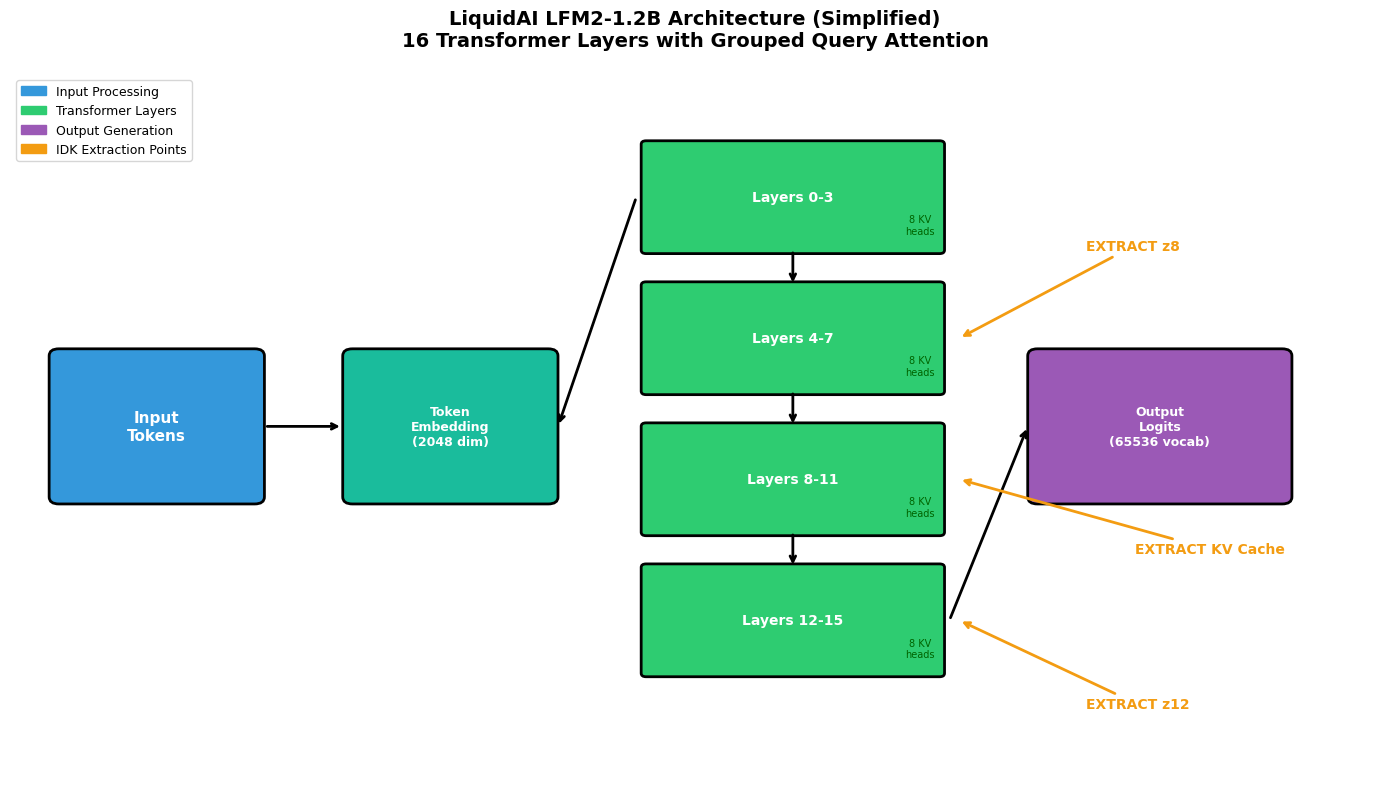


LFM2 processes text through 16 transformer layers.
Each layer has 8 key-value attention heads that 'look at' different aspects.
We extract hidden states at layers 8 and 12 to measure consistency.



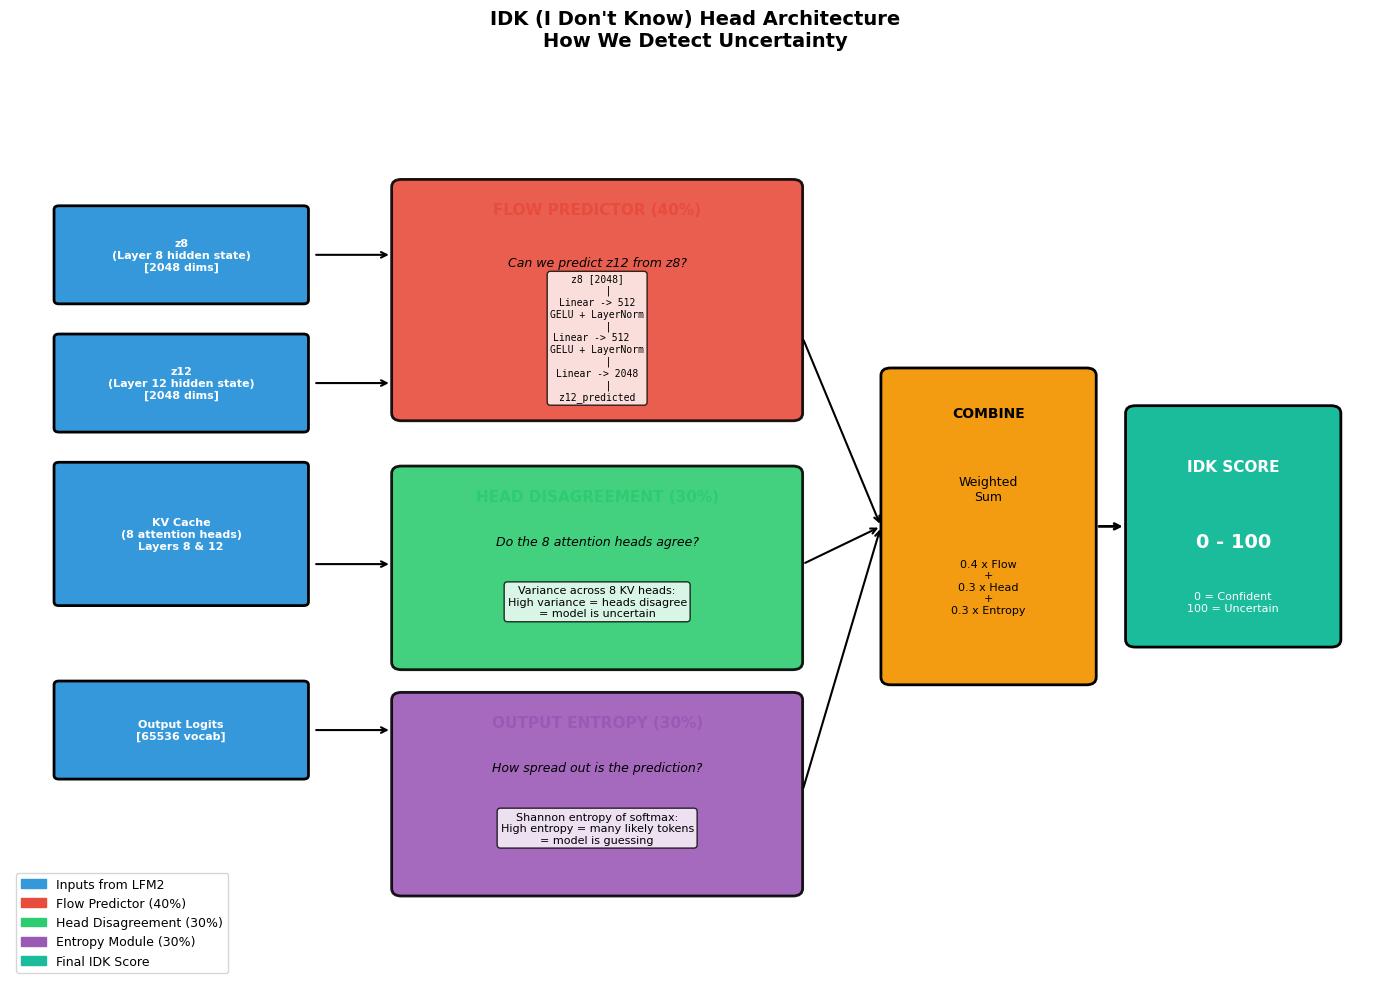


THE IDK HEAD COMBINES THREE SIGNALS:

1. FLOW PREDICTION (40%)
   - Trains an MLP to predict layer 12 from layer 8
   - High prediction error = unusual/uncertain input

2. HEAD DISAGREEMENT (30%)
   - Measures variance across the 8 attention heads
   - High variance = heads can't agree = uncertainty

3. OUTPUT ENTROPY (30%)
   - Measures spread of the output probability distribution
   - High entropy = many plausible next tokens = guessing

All three signals are combined into a single 0-100 score.



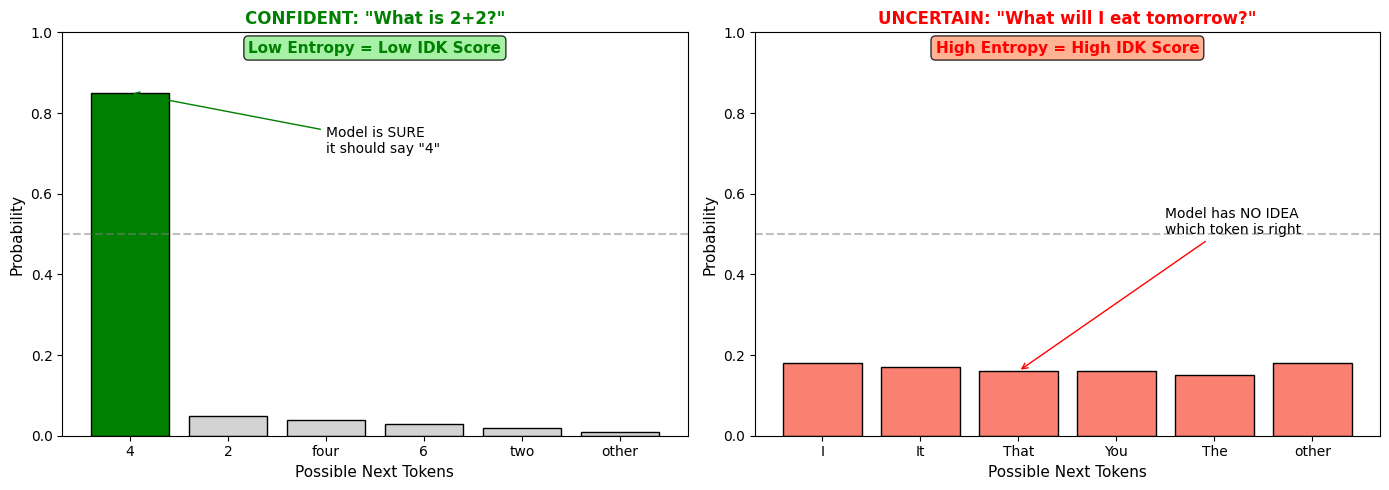


INTUITION: When the model KNOWS something, it's confident about
the next word. When it DOESN'T KNOW, it spreads probability across
many possible words - which we detect as high entropy.



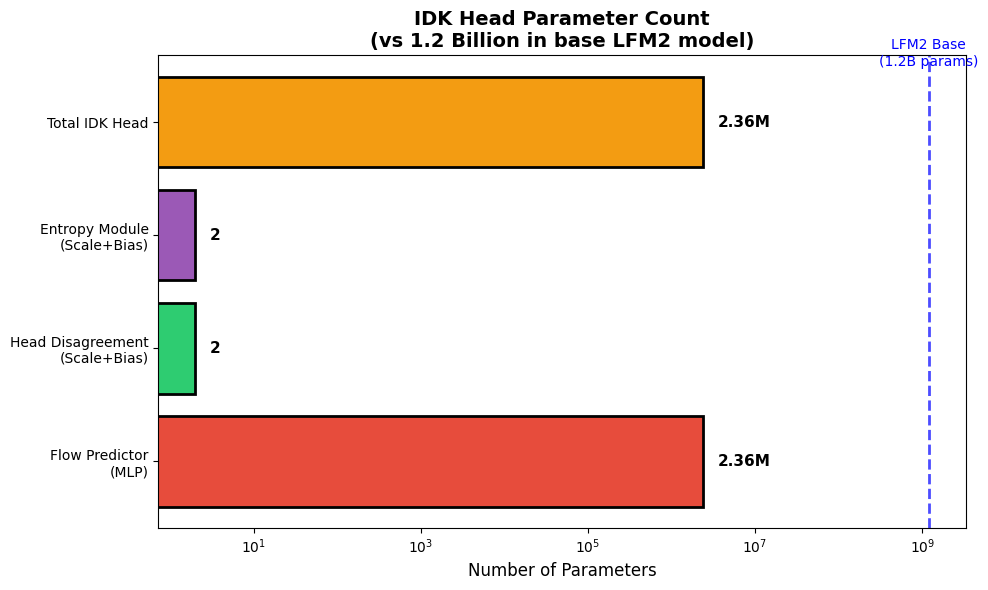


The IDK head adds only ~2.4M parameters (0.2% of the base model).
Most parameters are in the Flow Predictor MLP that learns to predict
how information should flow from layer 8 to layer 12.



                         SUMMARY

HOW THE IDK SYSTEM WORKS:

1. LFM2 processes your question through 16 transformer layers

2. We extract "snapshots" at layers 8 and 12:
   - Hidden states (z8, z12): What the model is "thinking"
   - KV Cache: What each attention head is focusing on
   - Output logits: The final prediction probabilities

3. The IDK Head analyzes these snapshots:
   - Flow Predictor: Is z12 predictable from z8? (trained via MSE loss)
   - Head Disagreement: Do the 8 attention heads agree?
   - Entropy: Is the model confident in its prediction?

4. These three signals are combined into a single 0-100 score:
   - 0-30:  Model is confident (probably reliable)
   - 30-50: Moderate confidence (likely fine)
   - 50-70: Uncertain (verify the output)
   - 70-100: Very uncertain (high hall

In [11]:
# =============================================================================
# VISUALIZATION: Training Loss & Model Architecture
# =============================================================================
# Run this cell after training to visualize what happened and understand
# how the IDK (I Don't Know) system works.
# =============================================================================

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch
import numpy as np

# Set style
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# =============================================================================
# FIGURE 1: Training Loss Curve
# =============================================================================

fig1, ax1 = plt.subplots(figsize=(10, 5))

# Training loss data from your run
epochs = [1, 5, 10, 15]
losses = [0.115839, 0.051918, 0.040745, 0.039628]

# Plot
ax1.plot(epochs, losses, 'b-o', linewidth=2, markersize=10, label='Training Loss')
ax1.fill_between(epochs, losses, alpha=0.3)

# Annotations
ax1.annotate('Initial: Learning basic patterns',
             xy=(1, 0.115839), xytext=(3, 0.10),
             fontsize=10, arrowprops=dict(arrowstyle='->', color='gray'))
ax1.annotate('Converged: IDK head trained',
             xy=(15, 0.039628), xytext=(11, 0.06),
             fontsize=10, arrowprops=dict(arrowstyle='->', color='gray'))

ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss (MSE)', fontsize=12)
ax1.set_title('IDK Head Training Progress\n(Lower = Better at predicting layer 12 from layer 8)',
              fontsize=14, fontweight='bold')
ax1.set_xlim(0, 16)
ax1.set_ylim(0, 0.13)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper right')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("The IDK head learns to predict how information flows through the model.")
print("Lower loss = better understanding of normal model behavior.")
print("="*70 + "\n")


# =============================================================================
# FIGURE 2: LFM2 Base Model Architecture (Simplified)
# =============================================================================

fig2, ax2 = plt.subplots(figsize=(14, 8))
ax2.set_xlim(0, 14)
ax2.set_ylim(0, 10)
ax2.axis('off')
ax2.set_title('LiquidAI LFM2-1.2B Architecture (Simplified)\n16 Transformer Layers with Grouped Query Attention',
              fontsize=14, fontweight='bold', pad=20)

# Colors
colors = {
    'input': '#3498db',
    'layer': '#2ecc71',
    'attention': '#e74c3c',
    'output': '#9b59b6',
    'extract': '#f39c12'
}

# Input
input_box = FancyBboxPatch((0.5, 4), 2, 2, boxstyle="round,pad=0.1",
                            facecolor=colors['input'], edgecolor='black', linewidth=2)
ax2.add_patch(input_box)
ax2.text(1.5, 5, 'Input\nTokens', ha='center', va='center', fontsize=11, fontweight='bold', color='white')

# Embedding
emb_box = FancyBboxPatch((3.5, 4), 2, 2, boxstyle="round,pad=0.1",
                          facecolor='#1abc9c', edgecolor='black', linewidth=2)
ax2.add_patch(emb_box)
ax2.text(4.5, 5, 'Token\nEmbedding\n(2048 dim)', ha='center', va='center', fontsize=9, fontweight='bold', color='white')

# Arrow
ax2.annotate('', xy=(3.4, 5), xytext=(2.6, 5),
            arrowprops=dict(arrowstyle='->', color='black', lw=2))

# Transformer layers (stacked)
layer_positions = [(6.5, 7.5), (6.5, 5.5), (6.5, 3.5), (6.5, 1.5)]
layer_labels = ['Layers 0-3', 'Layers 4-7', 'Layers 8-11', 'Layers 12-15']

for i, (pos, label) in enumerate(zip(layer_positions, layer_labels)):
    # Layer box
    layer_box = FancyBboxPatch((pos[0], pos[1]), 3, 1.5, boxstyle="round,pad=0.05",
                                facecolor=colors['layer'], edgecolor='black', linewidth=2)
    ax2.add_patch(layer_box)
    ax2.text(pos[0]+1.5, pos[1]+0.75, label, ha='center', va='center',
             fontsize=10, fontweight='bold', color='white')

    # Add attention heads indicator
    ax2.text(pos[0]+2.8, pos[1]+0.2, '8 KV\nheads', ha='center', va='bottom',
             fontsize=7, color='darkgreen')

# Arrows between layers
ax2.annotate('', xy=(5.6, 5), xytext=(6.4, 8.25), arrowprops=dict(arrowstyle='->', color='black', lw=2))
for i in range(3):
    y_start = 7.5 - i*2
    y_end = 5.5 - i*2
    ax2.annotate('', xy=(8, y_end+1.5), xytext=(8, y_start),
                arrowprops=dict(arrowstyle='->', color='black', lw=2))

# Output
output_box = FancyBboxPatch((10.5, 4), 2.5, 2, boxstyle="round,pad=0.1",
                             facecolor=colors['output'], edgecolor='black', linewidth=2)
ax2.add_patch(output_box)
ax2.text(11.75, 5, 'Output\nLogits\n(65536 vocab)', ha='center', va='center',
         fontsize=9, fontweight='bold', color='white')

ax2.annotate('', xy=(10.4, 5), xytext=(9.6, 2.25),
            arrowprops=dict(arrowstyle='->', color='black', lw=2))

# Extraction points for IDK
ax2.annotate('EXTRACT z8', xy=(9.7, 6.25), xytext=(11, 7.5),
            fontsize=10, fontweight='bold', color=colors['extract'],
            arrowprops=dict(arrowstyle='->', color=colors['extract'], lw=2))
ax2.annotate('EXTRACT z12', xy=(9.7, 2.25), xytext=(11, 1),
            fontsize=10, fontweight='bold', color=colors['extract'],
            arrowprops=dict(arrowstyle='->', color=colors['extract'], lw=2))
ax2.annotate('EXTRACT KV Cache', xy=(9.7, 4.25), xytext=(11.5, 3.2),
            fontsize=10, fontweight='bold', color=colors['extract'],
            arrowprops=dict(arrowstyle='->', color=colors['extract'], lw=2))

# Legend
legend_elements = [
    mpatches.Patch(color=colors['input'], label='Input Processing'),
    mpatches.Patch(color=colors['layer'], label='Transformer Layers'),
    mpatches.Patch(color=colors['output'], label='Output Generation'),
    mpatches.Patch(color=colors['extract'], label='IDK Extraction Points'),
]
ax2.legend(handles=legend_elements, loc='upper left', fontsize=9)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("LFM2 processes text through 16 transformer layers.")
print("Each layer has 8 key-value attention heads that 'look at' different aspects.")
print("We extract hidden states at layers 8 and 12 to measure consistency.")
print("="*70 + "\n")


# =============================================================================
# FIGURE 3: IDK Head Architecture
# =============================================================================

fig3, ax3 = plt.subplots(figsize=(14, 10))
ax3.set_xlim(0, 14)
ax3.set_ylim(0, 12)
ax3.axis('off')
ax3.set_title('IDK (I Don\'t Know) Head Architecture\nHow We Detect Uncertainty',
              fontsize=14, fontweight='bold', pad=20)

# Colors for IDK components
idk_colors = {
    'input': '#3498db',
    'flow': '#e74c3c',
    'head': '#2ecc71',
    'entropy': '#9b59b6',
    'combine': '#f39c12',
    'output': '#1abc9c'
}

# === INPUT SIGNALS (left side) ===

# z8 input
z8_box = FancyBboxPatch((0.5, 9), 2.5, 1.2, boxstyle="round,pad=0.05",
                         facecolor=idk_colors['input'], edgecolor='black', linewidth=2)
ax3.add_patch(z8_box)
ax3.text(1.75, 9.6, 'z8\n(Layer 8 hidden state)\n[2048 dims]',
         ha='center', va='center', fontsize=8, fontweight='bold', color='white')

# z12 input
z12_box = FancyBboxPatch((0.5, 7.3), 2.5, 1.2, boxstyle="round,pad=0.05",
                          facecolor=idk_colors['input'], edgecolor='black', linewidth=2)
ax3.add_patch(z12_box)
ax3.text(1.75, 7.9, 'z12\n(Layer 12 hidden state)\n[2048 dims]',
         ha='center', va='center', fontsize=8, fontweight='bold', color='white')

# KV Cache input
kv_box = FancyBboxPatch((0.5, 5), 2.5, 1.8, boxstyle="round,pad=0.05",
                         facecolor=idk_colors['input'], edgecolor='black', linewidth=2)
ax3.add_patch(kv_box)
ax3.text(1.75, 5.9, 'KV Cache\n(8 attention heads)\nLayers 8 & 12',
         ha='center', va='center', fontsize=8, fontweight='bold', color='white')

# Logits input
logits_box = FancyBboxPatch((0.5, 2.7), 2.5, 1.2, boxstyle="round,pad=0.05",
                             facecolor=idk_colors['input'], edgecolor='black', linewidth=2)
ax3.add_patch(logits_box)
ax3.text(1.75, 3.3, 'Output Logits\n[65536 vocab]',
         ha='center', va='center', fontsize=8, fontweight='bold', color='white')


# === COMPONENT 1: Flow Predictor (40%) ===

flow_box = FancyBboxPatch((4, 7.5), 4, 3, boxstyle="round,pad=0.1",
                           facecolor=idk_colors['flow'], edgecolor='black', linewidth=2, alpha=0.9)
ax3.add_patch(flow_box)

ax3.text(6, 10.2, 'FLOW PREDICTOR (40%)', ha='center', va='center',
         fontsize=11, fontweight='bold', color=idk_colors['flow'])
ax3.text(6, 9.5, 'Can we predict z12 from z8?', ha='center', va='center',
         fontsize=9, fontstyle='italic')

# MLP architecture inside
mlp_text = '''z8 [2048]
    |
Linear -> 512
GELU + LayerNorm
    |
Linear -> 512
GELU + LayerNorm
    |
Linear -> 2048
    |
z12_predicted'''
ax3.text(6, 8.5, mlp_text, ha='center', va='center', fontsize=7,
         family='monospace', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Arrows
ax3.annotate('', xy=(3.9, 9.6), xytext=(3.1, 9.6), arrowprops=dict(arrowstyle='->', color='black', lw=1.5))
ax3.annotate('', xy=(3.9, 7.9), xytext=(3.1, 7.9), arrowprops=dict(arrowstyle='->', color='black', lw=1.5))


# === COMPONENT 2: Head Disagreement (30%) ===

head_box = FancyBboxPatch((4, 4.2), 4, 2.5, boxstyle="round,pad=0.1",
                           facecolor=idk_colors['head'], edgecolor='black', linewidth=2, alpha=0.9)
ax3.add_patch(head_box)

ax3.text(6, 6.4, 'HEAD DISAGREEMENT (30%)', ha='center', va='center',
         fontsize=11, fontweight='bold', color=idk_colors['head'])
ax3.text(6, 5.8, 'Do the 8 attention heads agree?', ha='center', va='center',
         fontsize=9, fontstyle='italic')

head_detail = '''Variance across 8 KV heads:
High variance = heads disagree
= model is uncertain'''
ax3.text(6, 5, head_detail, ha='center', va='center', fontsize=8,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax3.annotate('', xy=(3.9, 5.5), xytext=(3.1, 5.5), arrowprops=dict(arrowstyle='->', color='black', lw=1.5))


# === COMPONENT 3: Entropy (30%) ===

entropy_box = FancyBboxPatch((4, 1.2), 4, 2.5, boxstyle="round,pad=0.1",
                              facecolor=idk_colors['entropy'], edgecolor='black', linewidth=2, alpha=0.9)
ax3.add_patch(entropy_box)

ax3.text(6, 3.4, 'OUTPUT ENTROPY (30%)', ha='center', va='center',
         fontsize=11, fontweight='bold', color=idk_colors['entropy'])
ax3.text(6, 2.8, 'How spread out is the prediction?', ha='center', va='center',
         fontsize=9, fontstyle='italic')

entropy_detail = '''Shannon entropy of softmax:
High entropy = many likely tokens
= model is guessing'''
ax3.text(6, 2, entropy_detail, ha='center', va='center', fontsize=8,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax3.annotate('', xy=(3.9, 3.3), xytext=(3.1, 3.3), arrowprops=dict(arrowstyle='->', color='black', lw=1.5))


# === COMBINER ===

combine_box = FancyBboxPatch((9, 4), 2, 4, boxstyle="round,pad=0.1",
                              facecolor=idk_colors['combine'], edgecolor='black', linewidth=2)
ax3.add_patch(combine_box)

ax3.text(10, 7.5, 'COMBINE', ha='center', va='center', fontsize=10, fontweight='bold')
ax3.text(10, 6.5, 'Weighted\nSum', ha='center', va='center', fontsize=9)
ax3.text(10, 5.2, '0.4 x Flow\n+\n0.3 x Head\n+\n0.3 x Entropy', ha='center', va='center', fontsize=8)

# Arrows to combiner
ax3.annotate('', xy=(8.9, 6), xytext=(8.1, 8.5), arrowprops=dict(arrowstyle='->', color='black', lw=1.5))
ax3.annotate('', xy=(8.9, 6), xytext=(8.1, 5.5), arrowprops=dict(arrowstyle='->', color='black', lw=1.5))
ax3.annotate('', xy=(8.9, 6), xytext=(8.1, 2.5), arrowprops=dict(arrowstyle='->', color='black', lw=1.5))


# === OUTPUT ===

output_box = FancyBboxPatch((11.5, 4.5), 2, 3, boxstyle="round,pad=0.1",
                             facecolor=idk_colors['output'], edgecolor='black', linewidth=2)
ax3.add_patch(output_box)

ax3.text(12.5, 6.8, 'IDK SCORE', ha='center', va='center', fontsize=11, fontweight='bold', color='white')
ax3.text(12.5, 5.8, '0 - 100', ha='center', va='center', fontsize=14, fontweight='bold', color='white')
ax3.text(12.5, 5, '0 = Confident\n100 = Uncertain', ha='center', va='center', fontsize=8, color='white')

ax3.annotate('', xy=(11.4, 6), xytext=(11.1, 6), arrowprops=dict(arrowstyle='->', color='black', lw=2))

# Legend
legend_elements = [
    mpatches.Patch(color=idk_colors['input'], label='Inputs from LFM2'),
    mpatches.Patch(color=idk_colors['flow'], label='Flow Predictor (40%)'),
    mpatches.Patch(color=idk_colors['head'], label='Head Disagreement (30%)'),
    mpatches.Patch(color=idk_colors['entropy'], label='Entropy Module (30%)'),
    mpatches.Patch(color=idk_colors['output'], label='Final IDK Score'),
]
ax3.legend(handles=legend_elements, loc='lower left', fontsize=9)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("THE IDK HEAD COMBINES THREE SIGNALS:")
print("")
print("1. FLOW PREDICTION (40%)")
print("   - Trains an MLP to predict layer 12 from layer 8")
print("   - High prediction error = unusual/uncertain input")
print("")
print("2. HEAD DISAGREEMENT (30%)")
print("   - Measures variance across the 8 attention heads")
print("   - High variance = heads can't agree = uncertainty")
print("")
print("3. OUTPUT ENTROPY (30%)")
print("   - Measures spread of the output probability distribution")
print("   - High entropy = many plausible next tokens = guessing")
print("")
print("All three signals are combined into a single 0-100 score.")
print("="*70 + "\n")


# =============================================================================
# FIGURE 4: How It Detects Uncertainty (Intuitive Example)
# =============================================================================

fig4, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Confident prediction
ax_conf = axes[0]
ax_conf.set_title('CONFIDENT: "What is 2+2?"', fontsize=12, fontweight='bold', color='green')

# Simulated probability distribution - peaked
tokens_conf = ['4', '2', 'four', '6', 'two', 'other']
probs_conf = [0.85, 0.05, 0.04, 0.03, 0.02, 0.01]
colors_conf = ['green' if i == 0 else 'lightgray' for i in range(len(tokens_conf))]

bars = ax_conf.bar(tokens_conf, probs_conf, color=colors_conf, edgecolor='black')
ax_conf.set_ylabel('Probability', fontsize=11)
ax_conf.set_xlabel('Possible Next Tokens', fontsize=11)
ax_conf.set_ylim(0, 1)
ax_conf.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)

# Annotations
ax_conf.annotate('Model is SURE\nit should say "4"',
                xy=(0, 0.85), xytext=(2, 0.7),
                fontsize=10, arrowprops=dict(arrowstyle='->', color='green'))
ax_conf.text(0.5, 0.95, 'Low Entropy = Low IDK Score', transform=ax_conf.transAxes,
            ha='center', fontsize=11, fontweight='bold', color='green',
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))


# Right: Uncertain prediction
ax_unc = axes[1]
ax_unc.set_title('UNCERTAIN: "What will I eat tomorrow?"', fontsize=12, fontweight='bold', color='red')

# Simulated probability distribution - flat
tokens_unc = ['I', 'It', 'That', 'You', 'The', 'other']
probs_unc = [0.18, 0.17, 0.16, 0.16, 0.15, 0.18]
colors_unc = ['salmon' for _ in range(len(tokens_unc))]

bars = ax_unc.bar(tokens_unc, probs_unc, color=colors_unc, edgecolor='black')
ax_unc.set_ylabel('Probability', fontsize=11)
ax_unc.set_xlabel('Possible Next Tokens', fontsize=11)
ax_unc.set_ylim(0, 1)
ax_unc.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)

# Annotations
ax_unc.annotate('Model has NO IDEA\nwhich token is right',
                xy=(2, 0.16), xytext=(3.5, 0.5),
                fontsize=10, arrowprops=dict(arrowstyle='->', color='red'))
ax_unc.text(0.5, 0.95, 'High Entropy = High IDK Score', transform=ax_unc.transAxes,
            ha='center', fontsize=11, fontweight='bold', color='red',
            bbox=dict(boxstyle='round', facecolor='lightsalmon', alpha=0.8))

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("INTUITION: When the model KNOWS something, it's confident about")
print("the next word. When it DOESN'T KNOW, it spreads probability across")
print("many possible words - which we detect as high entropy.")
print("="*70 + "\n")


# =============================================================================
# FIGURE 5: Parameter Count Summary
# =============================================================================

fig5, ax5 = plt.subplots(figsize=(10, 6))

components = ['Flow Predictor\n(MLP)', 'Head Disagreement\n(Scale+Bias)',
              'Entropy Module\n(Scale+Bias)', 'Total IDK Head']
params = [2364418, 2, 2, 2364422]  # Approximate counts

colors = ['#e74c3c', '#2ecc71', '#9b59b6', '#f39c12']

bars = ax5.barh(components, params, color=colors, edgecolor='black', linewidth=2)
ax5.set_xlabel('Number of Parameters', fontsize=12)
ax5.set_title('IDK Head Parameter Count\n(vs 1.2 Billion in base LFM2 model)', fontsize=14, fontweight='bold')
ax5.set_xscale('log')

# Add value labels
for bar, param in zip(bars, params):
    if param > 1000:
        label = f'{param/1e6:.2f}M'
    else:
        label = str(param)
    ax5.text(param * 1.5, bar.get_y() + bar.get_height()/2, label,
            va='center', fontsize=11, fontweight='bold')

# Add comparison annotation
ax5.axvline(x=1.2e9, color='blue', linestyle='--', alpha=0.7, linewidth=2)
ax5.text(1.2e9, 3.5, 'LFM2 Base\n(1.2B params)', ha='center', fontsize=10, color='blue')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("The IDK head adds only ~2.4M parameters (0.2% of the base model).")
print("Most parameters are in the Flow Predictor MLP that learns to predict")
print("how information should flow from layer 8 to layer 12.")
print("="*70 + "\n")


# =============================================================================
# SUMMARY
# =============================================================================

print("\n")
print("=" * 70)
print("                         SUMMARY")
print("=" * 70)
print("""
HOW THE IDK SYSTEM WORKS:

1. LFM2 processes your question through 16 transformer layers

2. We extract "snapshots" at layers 8 and 12:
   - Hidden states (z8, z12): What the model is "thinking"
   - KV Cache: What each attention head is focusing on
   - Output logits: The final prediction probabilities

3. The IDK Head analyzes these snapshots:
   - Flow Predictor: Is z12 predictable from z8? (trained via MSE loss)
   - Head Disagreement: Do the 8 attention heads agree?
   - Entropy: Is the model confident in its prediction?

4. These three signals are combined into a single 0-100 score:
   - 0-30:  Model is confident (probably reliable)
   - 30-50: Moderate confidence (likely fine)
   - 50-70: Uncertain (verify the output)
   - 70-100: Very uncertain (high hallucination risk)

KEY INSIGHT:
When a model KNOWS something, its internal processes are consistent.
When it's GUESSING, there are subtle signs of disagreement and confusion.
We detect these signs without needing any labeled "hallucination" data!
""")
print("=" * 70)

# Validating and testing against cosine similarity on a paraphrasing dataset

Loading cosine similarity data from GitHub...
Loaded matrix: 100 questions x 101 columns
Found 100 unique questions

Example questions:
  1. What is the first step an experienced engineer should take when invest...
  2. When a bug is reported, what should be done first before attempting a ...
  3. What is the initial action a senior engineer takes to debug an issue?...
  4. Before changing code to fix a bug, what should an engineer do first?...
  5. What is the most important first step in a professional debugging proc...

Computing IDK scores for all questions...



Computing IDK scores: 100%|██████████| 100/100 [00:02<00:00, 45.78it/s]



Successfully computed IDK for 100 questions


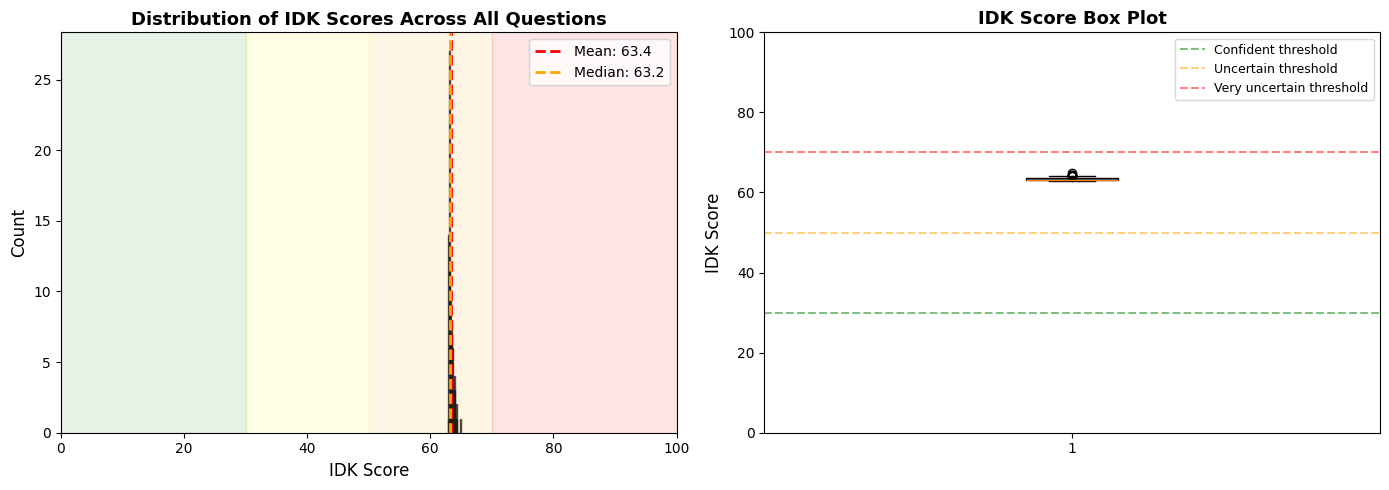


IDK SCORE STATISTICS
  Mean:   63.36
  Median: 63.24
  Std:    0.36
  Min:    62.85
  Max:    64.93


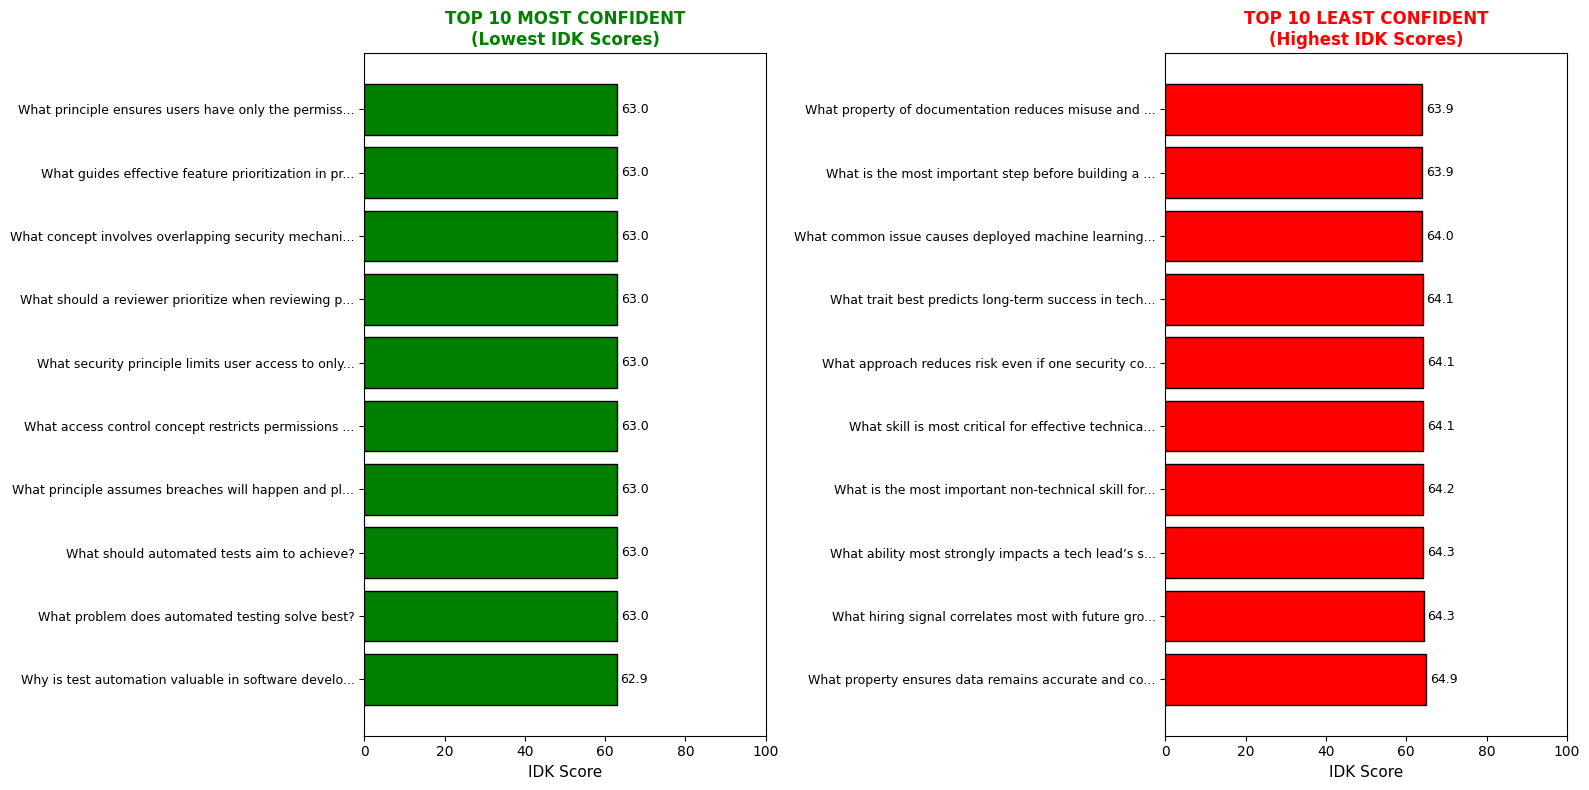

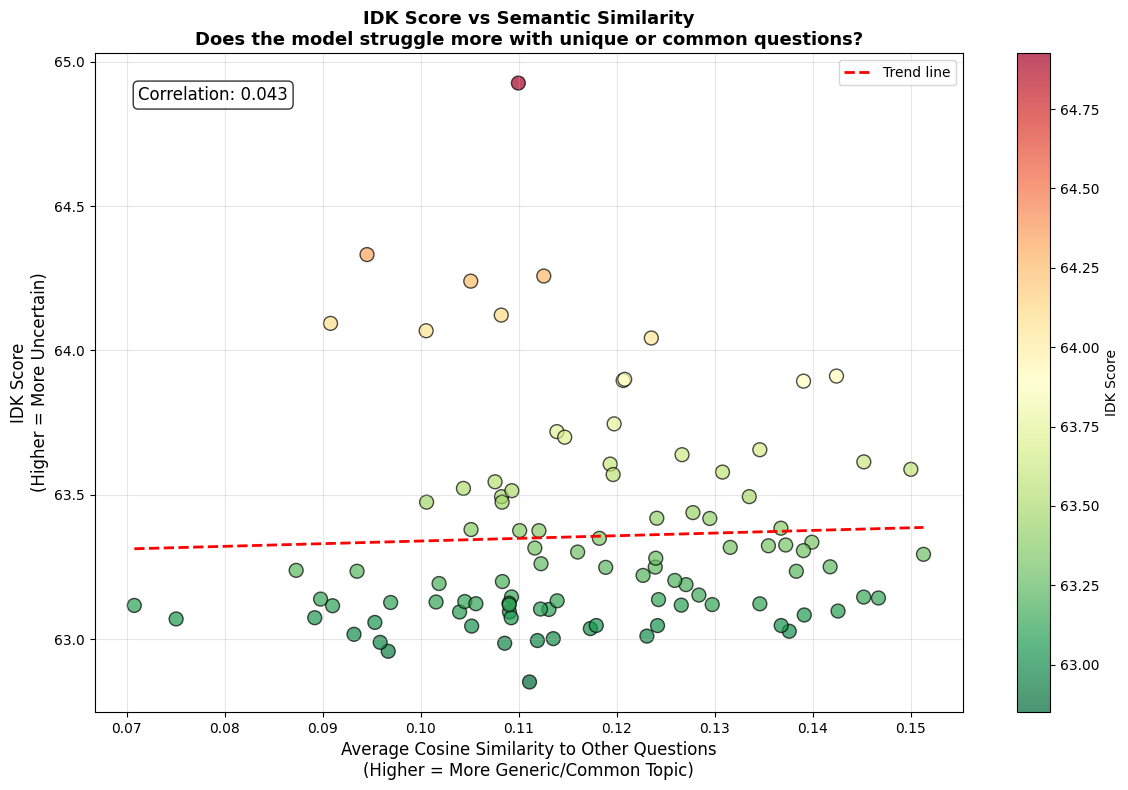


Correlation between average semantic similarity and IDK score: 0.043

IDK SCORES BY TOPIC CATEGORY
                    Mean IDK  Std IDK  Count
category                                    
Testing                63.01     0.12      5
Product Management     63.16     0.10      5
Agile                  63.17     0.18      3
Security               63.18     0.35      9
API Design             63.22     0.21      5
Incident Response      63.23     0.12     10
Code Review            63.23     0.22      5
Other                  63.26     0.40      6
Debugging              63.27     0.13      5
UX Design              63.34     0.20     10
Cloud/Distributed      63.40     0.37      4
Data Engineering       63.50     0.46     16
Documentation          63.50     0.38      5
Hiring/Career          63.73     0.52      3
Machine Learning       63.76     0.21      4
Leadership             63.87     0.47      5


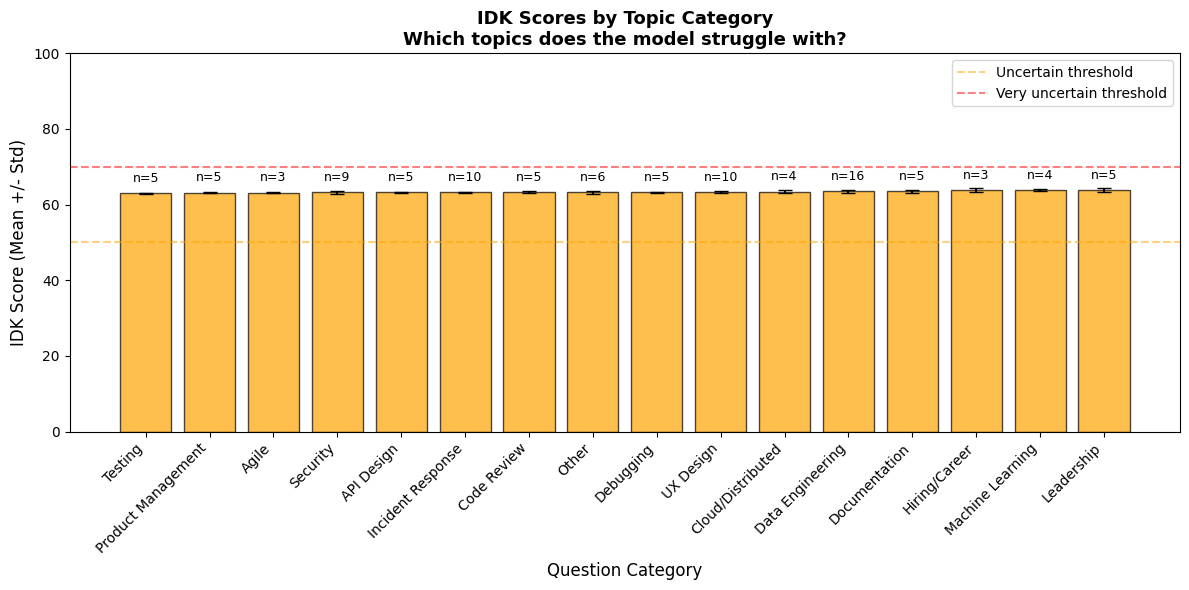

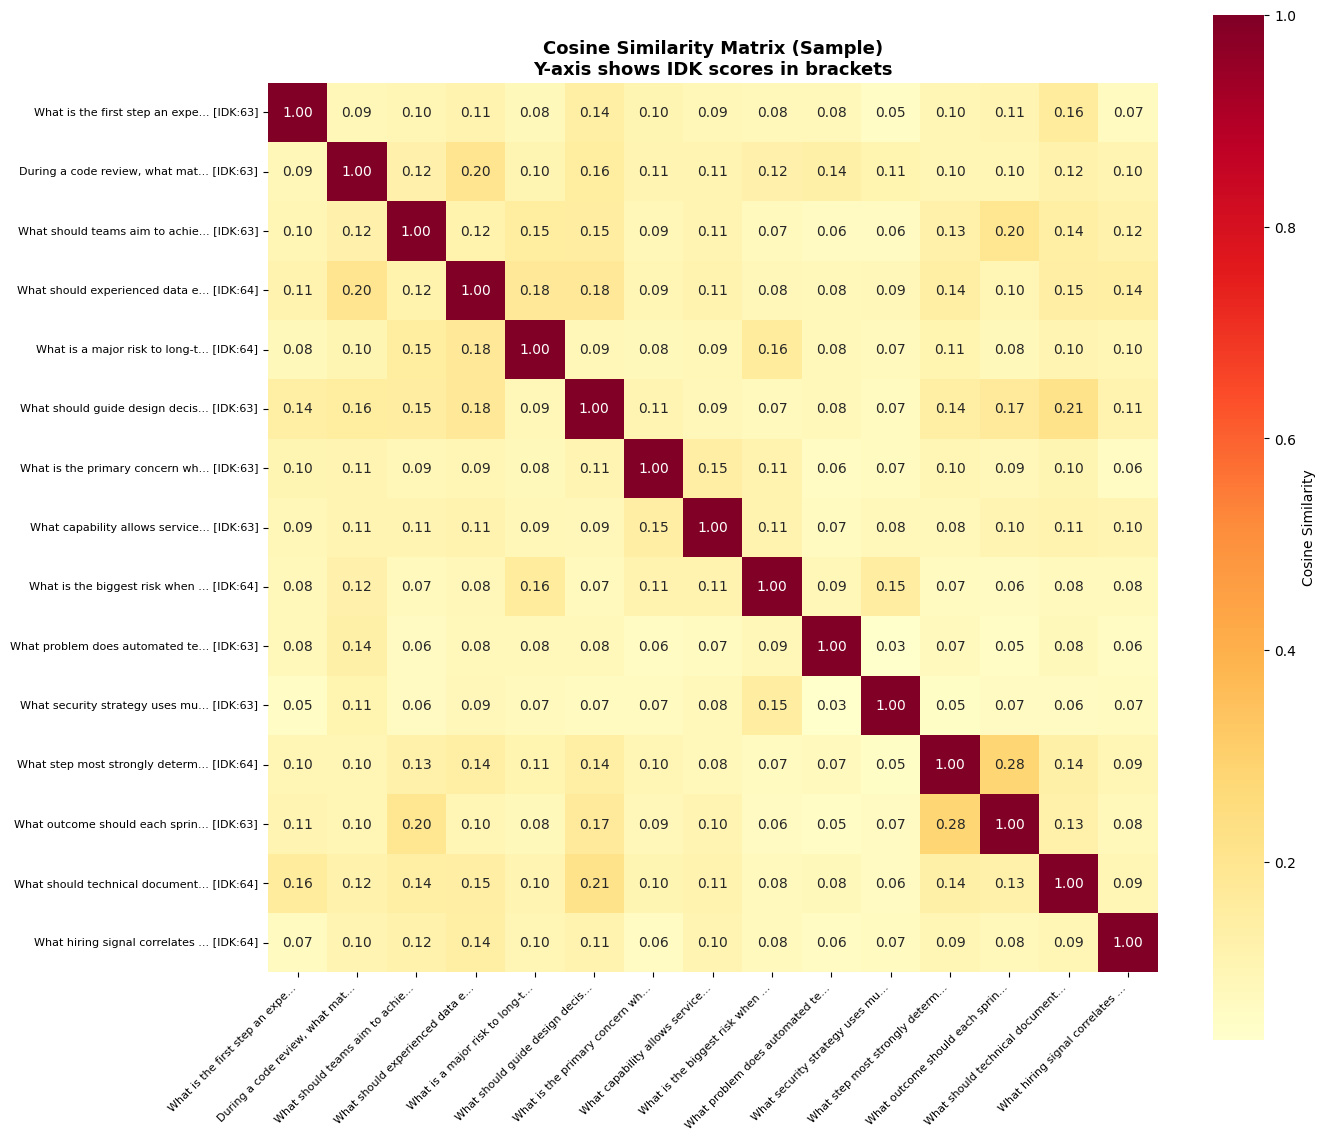

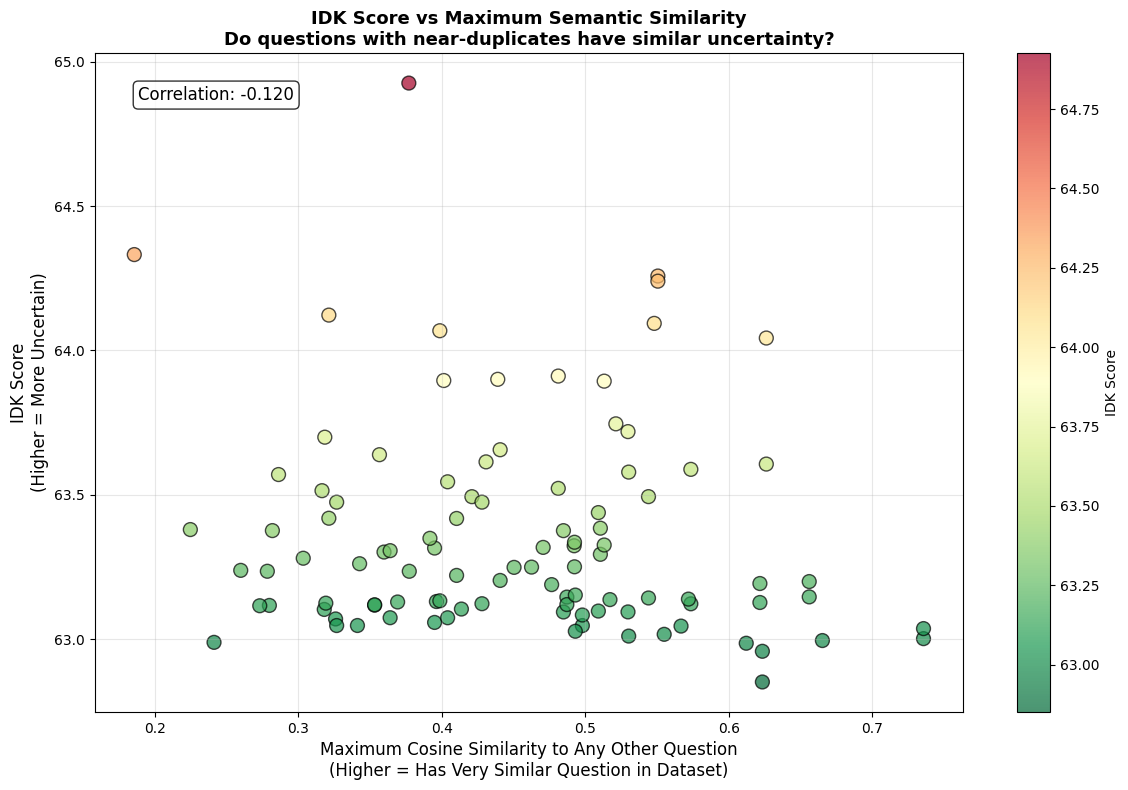


                           SUMMARY

DATASET: 100 software engineering questions
         with pairwise cosine similarity scores

IDK SCORE ANALYSIS:
  - Mean IDK Score:   63.4/100
  - Score Range:      62.9 - 64.9
  - Standard Dev:     0.4

CORRELATION WITH SEMANTIC SIMILARITY:
  - IDK vs Avg Similarity: 0.043
  - IDK vs Max Similarity: -0.120

INTERPRETATION:
  - Positive correlation: Model is more uncertain on generic questions
  - Negative correlation: Model is more uncertain on unique questions
  - Near-zero correlation: IDK is independent of semantic similarity

TOP CONFIDENT CATEGORIES:
                    Mean IDK  Std IDK  Count
category                                    
Testing                63.01     0.12      5
Product Management     63.16     0.10      5
Agile                  63.17     0.18      3

TOP UNCERTAIN CATEGORIES:
                  Mean IDK  Std IDK  Count
category                                  
Hiring/Career        63.73     0.52      3
Machine Learning  

In [12]:
# =============================================================================
# TEST IDK METRIC AGAINST COSINE SIMILARITY DATA
# =============================================================================
# This cell loads questions from the AI Bullshit Detector dataset and compares
# the IDK (I Don't Know) uncertainty scores with semantic similarity.
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Load the CSV from GitHub
url = "https://raw.githubusercontent.com/AvdMei/AI_Bullshit_Detector/main/data/output/llm_output_cosine_similarity.csv"
print("Loading cosine similarity data from GitHub...")
df = pd.read_csv(url)

print(f"Loaded matrix: {df.shape[0]} questions x {df.shape[1]} columns")

# The first column contains the questions, rest are similarity scores
questions = df.iloc[:, 0].tolist()
print(f"Found {len(questions)} unique questions")

# Show a few example questions
print("\nExample questions:")
for i, q in enumerate(questions[:5]):
    print(f"  {i+1}. {q[:70]}...")

# =============================================================================
# COMPUTE IDK SCORES FOR ALL QUESTIONS
# =============================================================================

print("\n" + "="*60)
print("Computing IDK scores for all questions...")
print("="*60 + "\n")

def get_idk_score(question):
    """Get IDK score for a single question (fast version - first token only)."""
    prompt = f"<|startoftext|><|im_start|>user\n{question}<|im_end|>\n<|im_start|>assistant\n"
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        outputs = model(input_ids, output_idk_score=True)

    idk = outputs.idk_score
    if isinstance(idk, torch.Tensor):
        idk = idk.item() if idk.numel() == 1 else idk[0].item()
    return idk

# Compute IDK for each question
idk_scores = []
for q in tqdm(questions, desc="Computing IDK scores"):
    try:
        idk = get_idk_score(q)
        idk_scores.append(idk)
    except Exception as e:
        print(f"Error on question: {q[:50]}... - {e}")
        idk_scores.append(None)

# Create results dataframe
results_df = pd.DataFrame({
    'question': questions,
    'idk_score': idk_scores
})

# Remove any failed questions
results_df = results_df.dropna()
print(f"\nSuccessfully computed IDK for {len(results_df)} questions")

# =============================================================================
# FIGURE 1: IDK Score Distribution
# =============================================================================

fig1, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax1 = axes[0]
ax1.hist(results_df['idk_score'], bins=20, color='steelblue', edgecolor='black', alpha=0.7)
ax1.axvline(results_df['idk_score'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {results_df['idk_score'].mean():.1f}")
ax1.axvline(results_df['idk_score'].median(), color='orange', linestyle='--', linewidth=2, label=f"Median: {results_df['idk_score'].median():.1f}")
ax1.set_xlabel('IDK Score', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Distribution of IDK Scores Across All Questions', fontsize=13, fontweight='bold')
ax1.legend()
ax1.set_xlim(0, 100)

# Add threshold regions
ax1.axvspan(0, 30, alpha=0.1, color='green', label='Confident')
ax1.axvspan(30, 50, alpha=0.1, color='yellow')
ax1.axvspan(50, 70, alpha=0.1, color='orange')
ax1.axvspan(70, 100, alpha=0.1, color='red')

# Box plot
ax2 = axes[1]
bp = ax2.boxplot(results_df['idk_score'], vert=True, patch_artist=True)
bp['boxes'][0].set_facecolor('steelblue')
ax2.set_ylabel('IDK Score', fontsize=12)
ax2.set_title('IDK Score Box Plot', fontsize=13, fontweight='bold')
ax2.set_ylim(0, 100)

# Add horizontal lines for thresholds
ax2.axhline(30, color='green', linestyle='--', alpha=0.5, label='Confident threshold')
ax2.axhline(50, color='orange', linestyle='--', alpha=0.5, label='Uncertain threshold')
ax2.axhline(70, color='red', linestyle='--', alpha=0.5, label='Very uncertain threshold')
ax2.legend(loc='upper right', fontsize=9)

plt.tight_layout()
plt.show()

# Print statistics
print("\n" + "="*60)
print("IDK SCORE STATISTICS")
print("="*60)
print(f"  Mean:   {results_df['idk_score'].mean():.2f}")
print(f"  Median: {results_df['idk_score'].median():.2f}")
print(f"  Std:    {results_df['idk_score'].std():.2f}")
print(f"  Min:    {results_df['idk_score'].min():.2f}")
print(f"  Max:    {results_df['idk_score'].max():.2f}")


# =============================================================================
# FIGURE 2: Top Most/Least Confident Questions
# =============================================================================

fig2, axes = plt.subplots(1, 2, figsize=(16, 8))

# Sort by IDK score
sorted_df = results_df.sort_values('idk_score')

# Most confident (lowest IDK)
n_show = 10
most_confident = sorted_df.head(n_show)
ax_conf = axes[0]
y_pos = range(n_show)
bars = ax_conf.barh(y_pos, most_confident['idk_score'], color='green', edgecolor='black')
ax_conf.set_yticks(y_pos)
ax_conf.set_yticklabels([q[:50] + '...' if len(q) > 50 else q for q in most_confident['question']], fontsize=9)
ax_conf.set_xlabel('IDK Score', fontsize=11)
ax_conf.set_title('TOP 10 MOST CONFIDENT\n(Lowest IDK Scores)', fontsize=12, fontweight='bold', color='green')
ax_conf.set_xlim(0, 100)
for bar, score in zip(bars, most_confident['idk_score']):
    ax_conf.text(score + 1, bar.get_y() + bar.get_height()/2, f'{score:.1f}', va='center', fontsize=9)

# Least confident (highest IDK)
least_confident = sorted_df.tail(n_show).iloc[::-1]
ax_unc = axes[1]
bars = ax_unc.barh(y_pos, least_confident['idk_score'], color='red', edgecolor='black')
ax_unc.set_yticks(y_pos)
ax_unc.set_yticklabels([q[:50] + '...' if len(q) > 50 else q for q in least_confident['question']], fontsize=9)
ax_unc.set_xlabel('IDK Score', fontsize=11)
ax_unc.set_title('TOP 10 LEAST CONFIDENT\n(Highest IDK Scores)', fontsize=12, fontweight='bold', color='red')
ax_unc.set_xlim(0, 100)
for bar, score in zip(bars, least_confident['idk_score']):
    ax_unc.text(score + 1, bar.get_y() + bar.get_height()/2, f'{score:.1f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()


# =============================================================================
# FIGURE 3: IDK vs Average Cosine Similarity (Semantic Uniqueness)
# =============================================================================

# Calculate average similarity for each question (excluding self-similarity)
cosine_matrix = df.iloc[:, 1:].values.astype(float)
n_questions = len(questions)

# Average similarity to other questions (measure of how "generic" a question is)
avg_similarities = []
for i in range(n_questions):
    # Get all similarities except self (diagonal = 1.0)
    sims = [cosine_matrix[i, j] for j in range(cosine_matrix.shape[1]) if i != j]
    avg_similarities.append(np.mean(sims))

results_df['avg_cosine_similarity'] = avg_similarities[:len(results_df)]

# Scatter plot
fig3, ax3 = plt.subplots(figsize=(12, 8))

scatter = ax3.scatter(results_df['avg_cosine_similarity'],
                      results_df['idk_score'],
                      c=results_df['idk_score'],
                      cmap='RdYlGn_r',
                      s=100,
                      alpha=0.7,
                      edgecolors='black')

ax3.set_xlabel('Average Cosine Similarity to Other Questions\n(Higher = More Generic/Common Topic)', fontsize=12)
ax3.set_ylabel('IDK Score\n(Higher = More Uncertain)', fontsize=12)
ax3.set_title('IDK Score vs Semantic Similarity\nDoes the model struggle more with unique or common questions?',
              fontsize=13, fontweight='bold')

plt.colorbar(scatter, label='IDK Score')

# Add trend line
z = np.polyfit(results_df['avg_cosine_similarity'], results_df['idk_score'], 1)
p = np.poly1d(z)
x_line = np.linspace(results_df['avg_cosine_similarity'].min(), results_df['avg_cosine_similarity'].max(), 100)
ax3.plot(x_line, p(x_line), "r--", linewidth=2, label=f'Trend line')

# Calculate correlation
corr = results_df['avg_cosine_similarity'].corr(results_df['idk_score'])
ax3.text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=ax3.transAxes,
         fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax3.legend()
ax3.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nCorrelation between average semantic similarity and IDK score: {corr:.3f}")


# =============================================================================
# FIGURE 4: Heatmap - IDK Scores by Question Topic Clusters
# =============================================================================

# Group questions by topic (based on keywords)
def categorize_question(q):
    q_lower = q.lower()
    if 'bug' in q_lower or 'debug' in q_lower or 'fix' in q_lower:
        return 'Debugging'
    elif 'code review' in q_lower or 'reviewer' in q_lower:
        return 'Code Review'
    elif 'incident' in q_lower or 'outage' in q_lower or 'postmortem' in q_lower:
        return 'Incident Response'
    elif 'security' in q_lower or 'access' in q_lower or 'permission' in q_lower:
        return 'Security'
    elif 'data' in q_lower or 'pipeline' in q_lower or 'data science' in q_lower:
        return 'Data Engineering'
    elif 'machine learning' in q_lower or 'ml' in q_lower or 'model' in q_lower:
        return 'Machine Learning'
    elif 'product' in q_lower or 'feature' in q_lower or 'roadmap' in q_lower:
        return 'Product Management'
    elif 'design' in q_lower or 'ux' in q_lower or 'interface' in q_lower:
        return 'UX Design'
    elif 'database' in q_lower or 'transaction' in q_lower:
        return 'Database'
    elif 'cloud' in q_lower or 'distributed' in q_lower or 'scale' in q_lower:
        return 'Cloud/Distributed'
    elif 'leadership' in q_lower or 'team' in q_lower or 'tech lead' in q_lower:
        return 'Leadership'
    elif 'api' in q_lower:
        return 'API Design'
    elif 'test' in q_lower or 'automation' in q_lower:
        return 'Testing'
    elif 'agile' in q_lower or 'sprint' in q_lower:
        return 'Agile'
    elif 'documentation' in q_lower:
        return 'Documentation'
    elif 'hiring' in q_lower or 'interview' in q_lower or 'engineer' in q_lower:
        return 'Hiring/Career'
    else:
        return 'Other'

results_df['category'] = results_df['question'].apply(categorize_question)

# Group statistics
category_stats = results_df.groupby('category').agg({
    'idk_score': ['mean', 'std', 'count']
}).round(2)
category_stats.columns = ['Mean IDK', 'Std IDK', 'Count']
category_stats = category_stats.sort_values('Mean IDK')

print("\n" + "="*60)
print("IDK SCORES BY TOPIC CATEGORY")
print("="*60)
print(category_stats.to_string())

# Bar chart by category
fig4, ax4 = plt.subplots(figsize=(12, 6))

categories = category_stats.index.tolist()
means = category_stats['Mean IDK'].tolist()
stds = category_stats['Std IDK'].tolist()
counts = category_stats['Count'].tolist()

# Color based on mean IDK
colors = ['green' if m < 50 else 'orange' if m < 65 else 'red' for m in means]

bars = ax4.bar(range(len(categories)), means, yerr=stds, capsize=5,
               color=colors, edgecolor='black', alpha=0.7)

ax4.set_xticks(range(len(categories)))
ax4.set_xticklabels(categories, rotation=45, ha='right', fontsize=10)
ax4.set_ylabel('IDK Score (Mean +/- Std)', fontsize=12)
ax4.set_xlabel('Question Category', fontsize=12)
ax4.set_title('IDK Scores by Topic Category\nWhich topics does the model struggle with?',
              fontsize=13, fontweight='bold')
ax4.set_ylim(0, 100)

# Add count labels
for bar, count in zip(bars, counts):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 3,
             f'n={count}', ha='center', fontsize=9)

# Add threshold lines
ax4.axhline(50, color='orange', linestyle='--', alpha=0.5, label='Uncertain threshold')
ax4.axhline(70, color='red', linestyle='--', alpha=0.5, label='Very uncertain threshold')
ax4.legend(loc='upper right')

plt.tight_layout()
plt.show()


# =============================================================================
# FIGURE 5: Cosine Similarity Heatmap with IDK Annotations
# =============================================================================

# Create a smaller heatmap with IDK scores as annotations
# Select a subset of diverse questions for readability
n_sample = 15
sample_indices = np.linspace(0, len(questions)-1, n_sample, dtype=int)

sample_questions = [questions[i][:30] + '...' for i in sample_indices]
sample_idk = [idk_scores[i] for i in sample_indices]
sample_cosine = cosine_matrix[sample_indices][:, sample_indices]

fig5, ax5 = plt.subplots(figsize=(14, 12))

# Heatmap
sns.heatmap(sample_cosine,
            xticklabels=sample_questions,
            yticklabels=[f"{q} [IDK:{idk:.0f}]" for q, idk in zip(sample_questions, sample_idk)],
            cmap='YlOrRd',
            annot=True,
            fmt='.2f',
            square=True,
            cbar_kws={'label': 'Cosine Similarity'},
            ax=ax5)

ax5.set_title('Cosine Similarity Matrix (Sample)\nY-axis shows IDK scores in brackets',
              fontsize=13, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)

plt.tight_layout()
plt.show()


# =============================================================================
# FIGURE 6: IDK Score vs Max Similarity (Finding Similar Questions)
# =============================================================================

# For each question, find its max similarity to any other question
max_similarities = []
for i in range(n_questions):
    sims = [cosine_matrix[i, j] for j in range(cosine_matrix.shape[1]) if i != j]
    max_similarities.append(max(sims) if sims else 0)

results_df['max_cosine_similarity'] = max_similarities[:len(results_df)]

fig6, ax6 = plt.subplots(figsize=(12, 8))

scatter = ax6.scatter(results_df['max_cosine_similarity'],
                      results_df['idk_score'],
                      c=results_df['idk_score'],
                      cmap='RdYlGn_r',
                      s=100,
                      alpha=0.7,
                      edgecolors='black')

ax6.set_xlabel('Maximum Cosine Similarity to Any Other Question\n(Higher = Has Very Similar Question in Dataset)', fontsize=12)
ax6.set_ylabel('IDK Score\n(Higher = More Uncertain)', fontsize=12)
ax6.set_title('IDK Score vs Maximum Semantic Similarity\nDo questions with near-duplicates have similar uncertainty?',
              fontsize=13, fontweight='bold')

plt.colorbar(scatter, label='IDK Score')

# Correlation
corr_max = results_df['max_cosine_similarity'].corr(results_df['idk_score'])
ax6.text(0.05, 0.95, f'Correlation: {corr_max:.3f}', transform=ax6.transAxes,
         fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax6.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# =============================================================================
# SUMMARY
# =============================================================================

print("\n" + "="*70)
print("                           SUMMARY")
print("="*70)
print(f"""
DATASET: {len(questions)} software engineering questions
         with pairwise cosine similarity scores

IDK SCORE ANALYSIS:
  - Mean IDK Score:   {results_df['idk_score'].mean():.1f}/100
  - Score Range:      {results_df['idk_score'].min():.1f} - {results_df['idk_score'].max():.1f}
  - Standard Dev:     {results_df['idk_score'].std():.1f}

CORRELATION WITH SEMANTIC SIMILARITY:
  - IDK vs Avg Similarity: {corr:.3f}
  - IDK vs Max Similarity: {corr_max:.3f}

INTERPRETATION:
  - Positive correlation: Model is more uncertain on generic questions
  - Negative correlation: Model is more uncertain on unique questions
  - Near-zero correlation: IDK is independent of semantic similarity

TOP CONFIDENT CATEGORIES:
{category_stats.head(3).to_string()}

TOP UNCERTAIN CATEGORIES:
{category_stats.tail(3).to_string()}
""")
print("="*70)

## save the model weights for HuggingFace

In [5]:
import torch
from google.colab import files

torch.save(model.idk_head.state_dict(), "pytorch_model.bin")
files.download("pytorch_model.bin")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Demo the Liquid AI model and Bullshit Detector in action

In [10]:


QUESTION = "What will I do tomorrow?"

# ============================================

# Template for LFM2
template = "<|startoftext|><|im_start|>user\n{question}<|im_end|>\n<|im_start|>assistant\n"

# Encode
prompt = template.format(question=QUESTION)
input_ids = tokenizer.encode(prompt, return_tensors="pt").to(DEVICE)

# Generate with IDK tracking
generated_tokens = []
idk_scores = []
current = input_ids
past = None

model.eval()
for _ in range(50):  # max tokens
    with torch.no_grad():
        outputs = model(current, past_key_values=past, output_idk_score=True)

    # Get IDK score
    idk = outputs.idk_score
    if isinstance(idk, torch.Tensor):
        idk = idk.item() if idk.numel() == 1 else idk[0].item()
    idk_scores.append(idk)

    # Sample next token
    logits = outputs.logits[:, -1, :]
    probs = F.softmax(logits / 0.3, dim=-1)  # temperature=0.3
    next_token = torch.multinomial(probs, num_samples=1)

    generated_tokens.append(next_token.item())

    # Check EOS
    if next_token.item() == tokenizer.eos_token_id:
        break

    past = outputs.past_key_values
    current = next_token

# Decode answer
answer = tokenizer.decode(generated_tokens, skip_special_tokens=True)
mean_idk = sum(idk_scores) / len(idk_scores) if idk_scores else 0

# Get label
if mean_idk < 30:
    label = "[GREEN] Confident"
elif mean_idk < 50:
    label = "[YELLOW] Moderate"
elif mean_idk < 70:
    label = "[ORANGE] Uncertain"
else:
    label = "[RED] Very Uncertain"

# Display results
print("=" * 60)
print("QUESTION:", QUESTION)
print("-" * 60)
print("ANSWER:", answer)
print("-" * 60)
print("IDK SCORE: {:.1f}/100 - {}".format(mean_idk, label))
print("=" * 60)
print("")
print("IDK Score Guide:")
print("  0-30  = Confident (likely reliable)")
print("  30-50 = Moderate (probably fine)")
print("  50-70 = Uncertain (verify this)")
print("  70-100 = Very Uncertain (high hallucination risk)")

QUESTION: What will I do tomorrow?
------------------------------------------------------------
ANSWER: Tomorrow, I'll be helping you organize your thoughts and tasks. Since I can't physically do things, I'll guide you through planning your day. Here's a general outline:

1. **Review Your Schedule**: Check what's already
------------------------------------------------------------
IDK SCORE: 64.0/100 - [ORANGE] Uncertain

IDK Score Guide:
  0-30  = Confident (likely reliable)
  30-50 = Moderate (probably fine)
  50-70 = Uncertain (verify this)
  70-100 = Very Uncertain (high hallucination risk)


# Optional: model diagnostics

In [ ]:
model = AutoModelForCausalLM.from_pretrained("LiquidAI/LFM2-1.2B", device_map="auto")

# Check model structure
print("Model type:", type(model))
print("\nNamed modules:")
for name, module in model.named_modules():
    if 'layer' in name.lower() or 'block' in name.lower():
        print(f"  {name}: {type(module).__name__}")

# Check past_key_values structure
input_ids = tokenizer.encode("Hello", return_tensors="pt").to(model.device)
with torch.no_grad():
    outputs = model(input_ids, use_cache=True, output_hidden_states=True)

print(f"\nHidden states: {len(outputs.hidden_states)} tensors")
print(f"Past key values: {len(outputs.past_key_values)} layers")

for i, kv in enumerate(outputs.past_key_values):
    if kv is not None and isinstance(kv, tuple) and len(kv) >= 2:
        k, v = kv[0], kv[1]
        print(f"  Layer {i}: K={k.shape}, V={v.shape}")
    else:
        print(f"  Layer {i}: {type(kv)}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

Liquid AI's LFM2-1.2B